## 1. Building ENM 

In [15]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from prody import *
from pylab import *
import Bio.PDB
from scipy.stats import pearsonr
from scipy.spatial import distance
from MDAnalysis.analysis import distances
from scipy.linalg import fractional_matrix_power
from scipy.optimize import minimize
from numpy import diff
import pandas as pd

In [16]:
file_dir = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_80_delT/"
#pdb = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/confout_1.gro"
pdb = file_dir+"confout_1.gro"
u = mda.Universe(pdb, pdb)
CA = u.select_atoms('name CA')
n_res = CA.n_residues
spring_constant = 1
temperature = 310
RT = temperature*8.314/1000

In [17]:
def get_positions(CA):
    positions = CA.positions/10 # In nano meters
    distance_map = distance.cdist(positions, positions)
    distance_map = np.repeat(np.repeat(distance_map, 3, axis=1), 3, axis=0)
    inv_distsq_map = distance_map**-2
    inv_distsq_map[inv_distsq_map == np.inf] = 0
    return positions, distance_map, inv_distsq_map

def get_kirchoff_matrix(distance_map, n_res, cutoff, spring_constant):
    kirchoff_matrix = np.ones((n_res*3, n_res*3))
    kirchoff_matrix[distance_map>cutoff] = 0
    kirchoff_matrix = spring_constant*kirchoff_matrix
    return kirchoff_matrix

def get_hessian(positions, kirchoff_matrix, inv_distsq_map, n_res):
    xx_distance_map = distance.cdist(positions[:, 0].reshape(-1, 1), positions[:, 0].reshape(-1, 1), lambda u, v: u-v)
    yy_distance_map = distance.cdist(positions[:, 1].reshape(-1, 1), positions[:, 1].reshape(-1, 1), lambda u, v: u-v)
    zz_distance_map = distance.cdist(positions[:, 2].reshape(-1, 1), positions[:, 2].reshape(-1, 1), lambda u, v: u-v)

    H = np.zeros((n_res*3, n_res*3))
    H[0::3, 0::3] = xx_distance_map * xx_distance_map
    H[1::3, 1::3] = yy_distance_map * yy_distance_map
    H[2::3, 2::3] = zz_distance_map * zz_distance_map
    H[0::3, 1::3] = xx_distance_map * yy_distance_map
    H[0::3, 2::3] = xx_distance_map * zz_distance_map
    H[1::3, 2::3] = yy_distance_map * zz_distance_map
    H[1::3, 0::3] = xx_distance_map * yy_distance_map
    H[2::3, 0::3] = xx_distance_map * zz_distance_map
    H[2::3, 1::3] = yy_distance_map * zz_distance_map
    H = -1 * kirchoff_matrix * inv_distsq_map * H

    for i in range(n_res):
        H[i*3+0, i*3+0] = -1*np.sum(H[i*3+0, 0::3])
        H[i*3+1, i*3+1] = -1*np.sum(H[i*3+1, 1::3])
        H[i*3+2, i*3+2] = -1*np.sum(H[i*3+2, 2::3])
        H[i*3+0, i*3+1] = -1*np.sum(H[i*3+0, 1::3])
        H[i*3+1, i*3+0] = H[i*3+0, i*3+1]
        H[i*3+0, i*3+2] = -1*np.sum(H[i*3+0, 2::3])
        H[i*3+2, i*3+0] = H[i*3+0, i*3+2]
        H[i*3+1, i*3+2] = -1*np.sum(H[i*3+1, 2::3])
        H[i*3+2, i*3+1] = H[i*3+1, i*3+2]  
    return H

def get_mass_matrix(CA):
    residue_mass = CA.residues.masses/1000
    residue_mass = np.repeat(residue_mass, 3)
    M = np.diag(residue_mass)
    M_f = fractional_matrix_power(M, -0.5)
    return M_f

def get_mass_weighted_H(M_f, H):
    H_m = (M_f@H)@M_f
    return H_m

def get_fluctuations(M_f, H_m, RT):
    [v, U_m] = np.linalg.eig(H_m)
    U_m = U_m[:, np.argsort(v)]
    v = v[np.argsort(v)]
    U_m = U_m.astype('float64')
    M_f = M_f.astype('float64')
    v = v.astype('float64')
    m = len(H_m[0])
    C = np.zeros((np.shape(H_m)))
    for i in range(len(v)-6):
        C += (np.outer((M_f@U_m[:, i+6]), U_m[:, i+6].T)@M_f)/v[i+6]
    C = RT*C
    sq_fluctuations = np.diag(C).reshape(-1,3).sum(axis=1)
    F = np.sqrt(sq_fluctuations)
    return sq_fluctuations, F

In [18]:
positions, distance_map, inv_distsq_map = get_positions(CA)
M_f = get_mass_matrix(CA)
def fluctuations(CA, n_res, cutoff, spring_constant):
    kirchoff_matrix = get_kirchoff_matrix(distance_map, n_res, cutoff, spring_constant)
    H = get_hessian(positions, kirchoff_matrix, inv_distsq_map, n_res)
    H_m = get_mass_weighted_H(M_f, H)
    sq_fluctuations, F = get_fluctuations(M_f, H_m, RT)
    return sq_fluctuations, F

/var/tmp/pbs.3547524.pbshpc/ipykernel_24042/2539767524.py:5: RuntimeWarning: divide by zero encountered in power
  inv_distsq_map = distance_map**-2


In [19]:
rmsf_L = np.genfromtxt(file_dir+'rmsf_chL.xvg', skip_header=17)[:, 1]
rmsf_H = np.genfromtxt(file_dir+'rmsf_chH.xvg', skip_header=17)[:, 1]
rmsf = np.hstack((rmsf_L, rmsf_H))*10

In [20]:
cutoff = range(9, 20)
pearson_corr = []
for Rc in cutoff:
    sq_fluctuations_P, F_P = fluctuations(CA, n_res, Rc/10, spring_constant)
    corr, _ = pearsonr(rmsf, F_P)
    pearson_corr.append(corr)

In [21]:
pearson_corr

[0.4262959911132315,
 0.5723548266520256,
 0.6307099049200099,
 0.6554687558773025,
 0.6566050576041969,
 0.6546914602768971,
 0.65226939814329,
 0.6512564701689475,
 0.6320903699625514,
 0.6047008324838762,
 0.5851107248348606]

Maximum pearson coefficient is 0.6566050576041969 at:  1.3 nanoseconds


Text(0, 0.5, 'Pearson Coefficient')

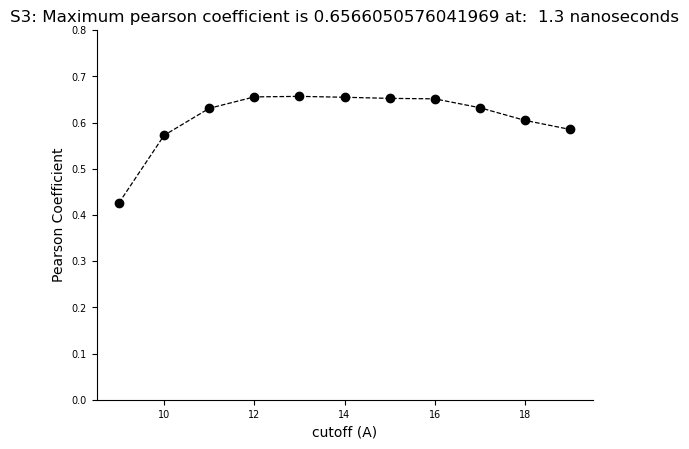

In [22]:
# With my 1ns rmsf
index = pearson_corr.index(max(pearson_corr))
opt_Rc = cutoff[index]/10
print('Maximum pearson coefficient is', max(pearson_corr), 'at: ', opt_Rc, 'nanoseconds')
ax = plt.subplot()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(cutoff, pearson_corr, marker='o', linestyle='--', color = 'black', linewidth = 0.9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(0, 0.8)
plt.title("S3: Maximum pearson coefficient is 0.6566050576041969 at:  1.3 nanoseconds")
plt.xlabel("cutoff (A)", fontsize = 10)
plt.ylabel("Pearson Coefficient", fontsize = 10)

Text(0, 0.5, 'Sq fluctuations (A2)')

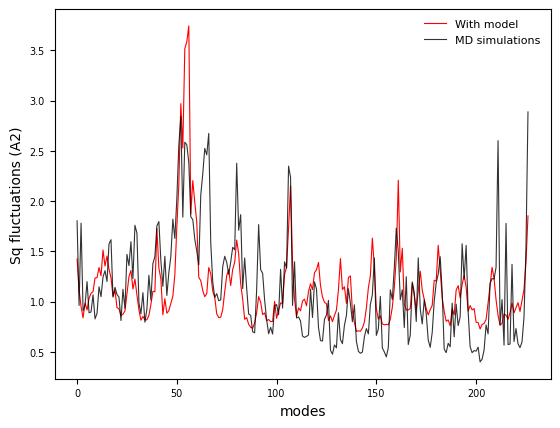

In [23]:
sq_fluctuations, F = fluctuations(CA, n_res, opt_Rc, spring_constant)
plt.plot(F, label = "With model", color = 'red', linewidth=0.8)
plt.plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.8)
plt.legend(frameon = False, prop={'size':8})
#plt.title("Comparing fluctuations: ENM vs MD simulation")
plt.xlabel("modes", fontsize = 10)
plt.ylabel("Sq fluctuations (A2)", fontsize = 10)

In [24]:
scale = (sq_fluctuations.mean()/rmsf.mean()**2)
print('The scale (kJ/A^2)is:', scale)

The scale (kJ/A^2)is: 1.1426132211741695


In [25]:
spring_constant = spring_constant*scale
sq_fluctuations_scale, F_scale = fluctuations(CA, n_res, opt_Rc, spring_constant)

Text(0, 0.5, 'Sq fluctuations (A2)')

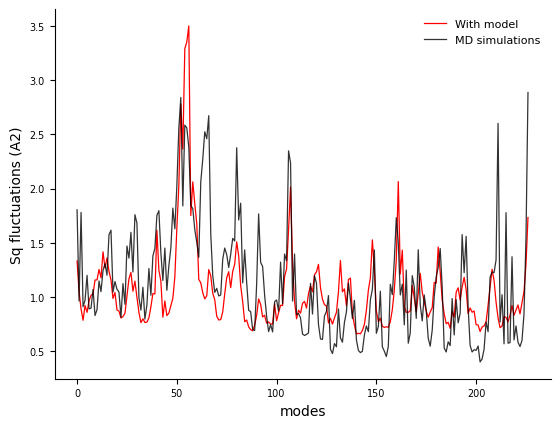

In [26]:
ax = plt.subplot()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(F_scale, label = "With model", color = 'red', linewidth=0.9)
ax.plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon = False, prop={'size':8})
#plt.title("Comparing fluctuations: ENM vs MD simulation")
plt.xlabel("modes", fontsize = 10)
plt.ylabel("Sq fluctuations (A2)", fontsize = 10)

Text(-50, 2, 'C')

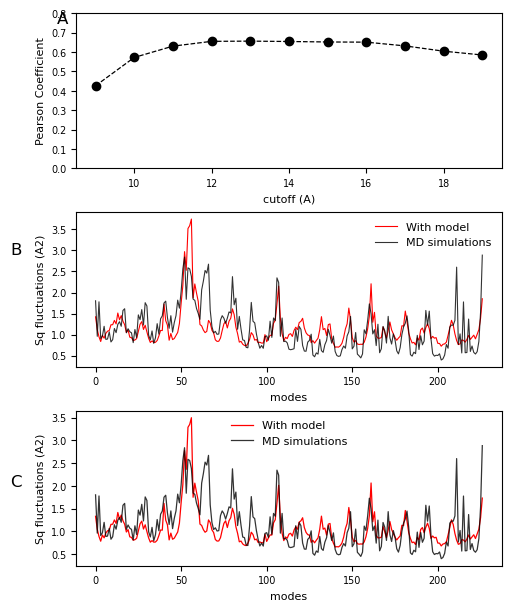

In [27]:
fig,axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 6), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

axes[1].plot(F, label = "With model", color = 'red', linewidth=0.8)
axes[1].plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.8)
axes[1].legend(frameon = False, prop={'size':8})
axes[1].set_xlabel("modes", fontsize = 8)
axes[1].set_ylabel("Sq fluctuations (A2)", fontsize = 8)
axes[1].text(-50, 3.4, "B", fontsize = 12)
axes[0].plot(cutoff, pearson_corr, marker='o', linestyle='--', color = 'black', linewidth = 0.9)
axes[0].set_ylim(0, 0.8)
axes[0].text(6.9, 0.75, "A", fontsize = 12)
axes[0].set_xlabel("cutoff (A)", fontsize = 8)
axes[0].set_ylabel("Pearson Coefficient", fontsize = 8)
axes[2].plot(F_scale, label = "With model", color = 'red', linewidth=0.9)
axes[2].plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.9)
axes[2].legend(frameon = False, prop={'size':8})
axes[2].set_xlabel("modes", fontsize = 8)
axes[2].set_ylabel("Sq fluctuations (A2)", fontsize = 8)
axes[2].text(-50, 3.3, "C", fontsize = 12)

## 2. Direction of change 

In [12]:
cutoff = opt_Rc
positions, distance_map, inv_distsq_map = get_positions(CA)
M_f = get_mass_matrix(CA)
kirchoff_matrix = get_kirchoff_matrix(distance_map, n_res, cutoff, spring_constant)
H = get_hessian(positions, kirchoff_matrix, inv_distsq_map, n_res)
H_m = get_mass_weighted_H(M_f, H)
[v, U_m] = np.linalg.eig(H_m)
arr_v = v
U_m = U_m[:, np.argsort(v)]
v = v[np.argsort(v)]  #eigenvalue
U = M_f @ U_m  #eigenvector

/var/tmp/pbs.3540590.pbshpc/ipykernel_26040/2539767524.py:5: RuntimeWarning: divide by zero encountered in power
  inv_distsq_map = distance_map**-2


#### Excitation along normal modes

In [16]:
box = file_dir+"box.pdb"
pdb = file_dir+"pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')
Um = U_m[6:26]
m = len(Um)

def excite(Um, box, delT, cycle):
    v_extra = np.zeros(Um[0].shape)
    v_extra = Um[cycle]
    v_extra = v_extra/ np.linalg.norm(v_extra)
    
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    u = mda.Universe(box,box)
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra.reshape(-1,3)

In [17]:
def save_gro(Um, v_extra, gro_in, delT, cycle):
    gro = mda.Universe(gro_in)
    frame = gro.trajectory[-1]
    for i in range(antibody.n_residues):
        for j in gro.residues[i].atoms.indices:
            frame.velocities[j] += v_extra[i]
    filename = file_dir+'{}_delT/{}_mode/md.gro'.format(delT, cycle)
    print(f"Writing new GRO file to {filename}")
    gro.atoms.write(filename, reindex=False)

In [19]:
gro_in = file_dir+"confout_1.gro"
delT = [90]
for i in delT:
    for j in range(20):
        v_extra = excite(Um, box, i, j)
        save_gro(Um, v_extra, gro_in, i, j)

Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_80_delT/90_delT/0_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_80_delT/90_delT/1_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_80_delT/90_delT/2_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_80_delT/90_delT/3_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_80_delT/90_delT/4_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_80_delT/90_delT/5_mode/md.gro
Writing new GRO 

#### RMSD Projections and plots

In [13]:
from MDAnalysis.analysis import align
import sys

box = file_dir+"box.pdb"
pdb = file_dir+"pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')
Um = U_m[6:26]
m = len(Um)

def excite(Um, box, delT, cycle):
    v_extra = np.zeros(U_m.shape[0])
    v_extra = Um[cycle]
    v_extra = v_extra/np.linalg.norm(v_extra)
    u = mda.Universe(box, box)
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite, (antibody.atoms.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra

def residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, selection, Um, cycle, delT):
    u = mda.Universe(pdb_mdenm, xtc_mdenm)
    v = mda.Universe(pdb_ref, pdb_ref)
    v_lrt = excite(Um, box, delT, cycle)
    v_lrt = v_lrt/np.linalg.norm(v_lrt) 
    u_fvca = u.select_atoms(selection)
    v_fvca = v.select_atoms(selection)
    dp = []
    for _ in u.trajectory:
        _ = align.alignto(u_fvca, v_fvca)
        deformation = (u_fvca.positions - v_fvca.positions).flatten()
        dp.append((np.dot(deformation, v_lrt)**2/u_fvca.n_residues)**0.5)
    return np.array(dp)

In [14]:
# For delT = 75
delT = 75
rd_75 = []
time = [i*10 for i in range(101)]
for i in range(20):
    pdb_mdenm = file_dir+"75_delT/{}_mode/pdb_mdenm.pdb".format(i)
    xtc_mdenm = file_dir+"75_delT/{}_mode/xtc_mdenm.xtc".format(i)    
    pdb_ref = file_dir+"pdb_ref.pdb"
    z_v = [residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, '(chainID A or chainID B) and name CA', Um, i, delT)]
    z_v = z_v[0]
    z_v = [i*0.1 for i in (z_v)]
    rd_75.append(z_v)
#     plt.figure(figsize=(8,6))
#     plt.rcParams['font.size'] = '16'
#     plt.plot(time, z_v, '*')
#     plt.title('delT = 75 K')
#     plt.xlabel('Time (ps)')
#     plt.ylabel('RMSD-v_extra (nm)')
#     plt.legend([str(i) for j in range(20)])
#     plt.legend([str(i)])

In [15]:
# For delT = 100
delT = 90
rd_90 = []
time = [i*10 for i in range(101)]
for i in range(20):
    pdb_mdenm = file_dir+"90_delT/{}_mode/pdb_mdenm.pdb".format(i)
    xtc_mdenm = file_dir+"90_delT/{}_mode/xtc_mdenm.xtc".format(i)
    pdb_ref = file_dir+"pdb_ref.pdb"
    z_v = [residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, '(chainID A or chainID B) and name CA', Um, i, delT)]
    z_v = z_v[0]
    z_v = [i*0.1 for i in (z_v)]
    rd_90.append(z_v)
#     plt.figure(figsize=(8,6))
#     plt.rcParams['font.size'] = '16'
#     plt.plot(time, z_v, '*')
#     plt.title('delT = 100 K')
#     plt.xlabel('Time (ps)')
#     plt.ylabel('RMSD-v_extra (nm)')
# #    plt.legend([str(i) for j in range(20)])
#     plt.legend([str(i)])

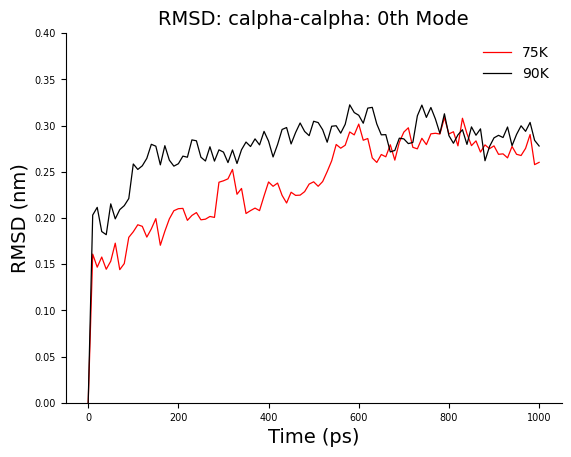

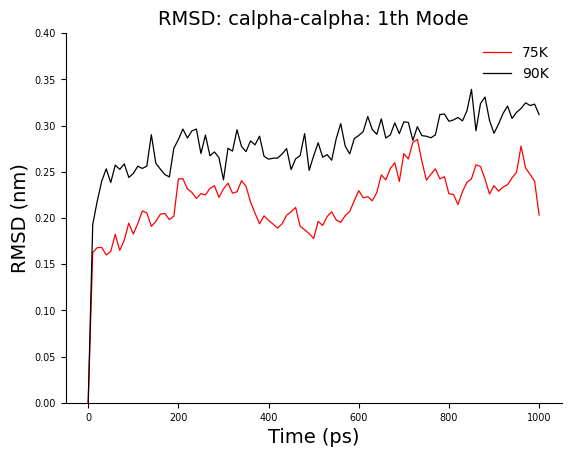

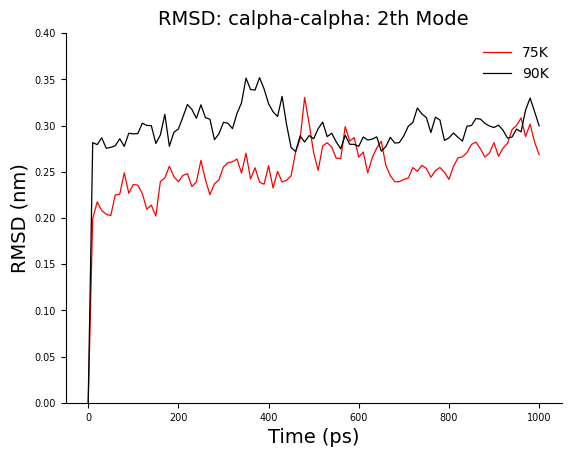

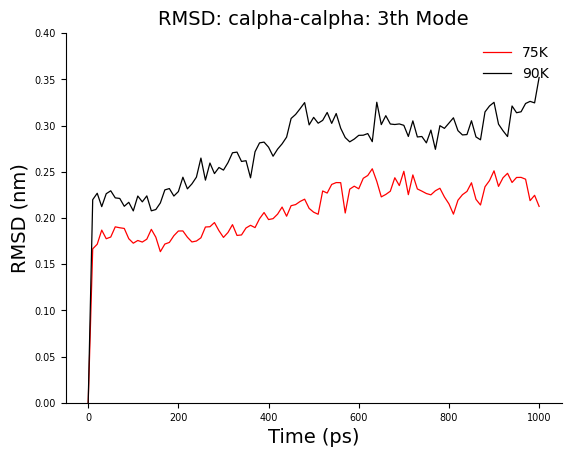

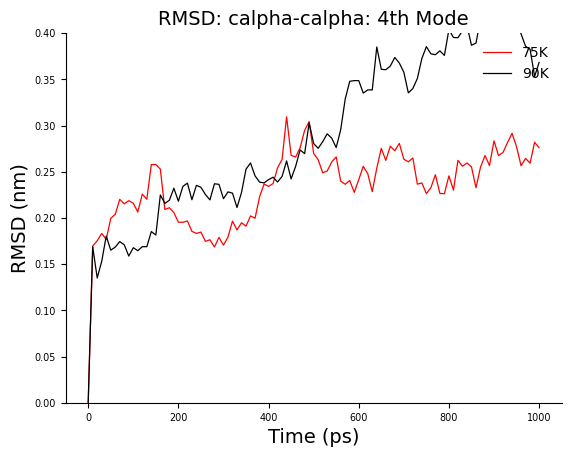

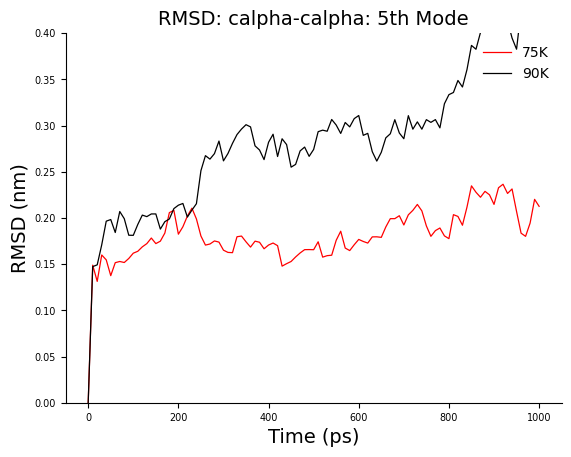

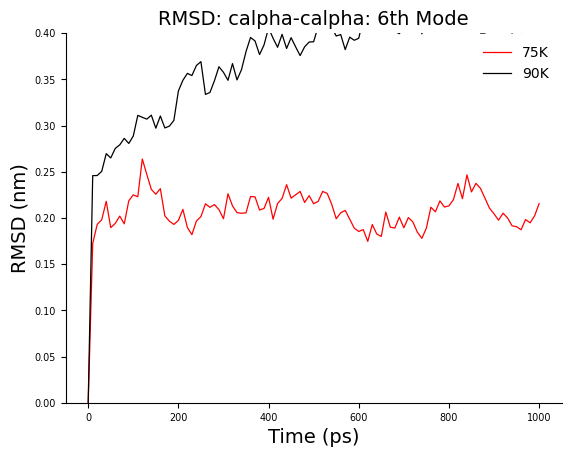

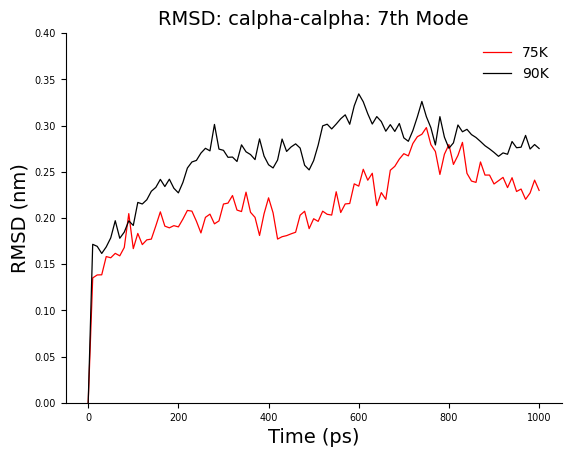

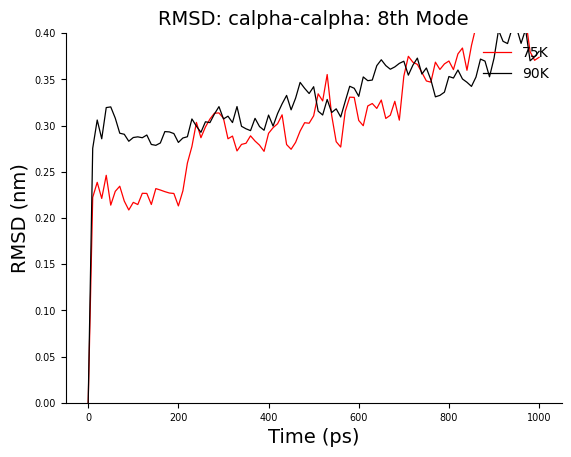

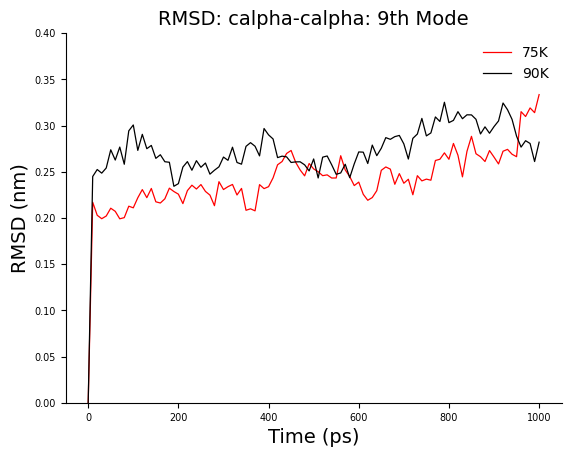

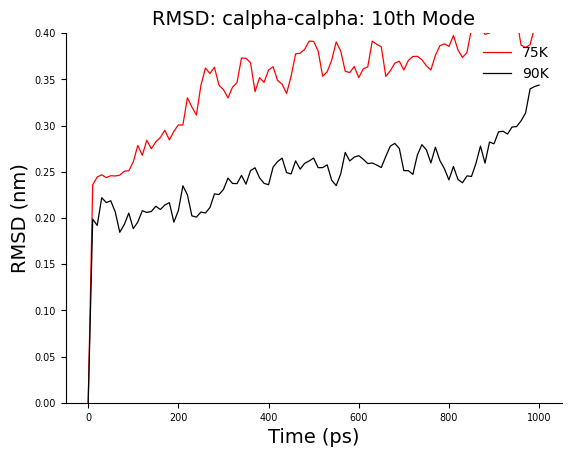

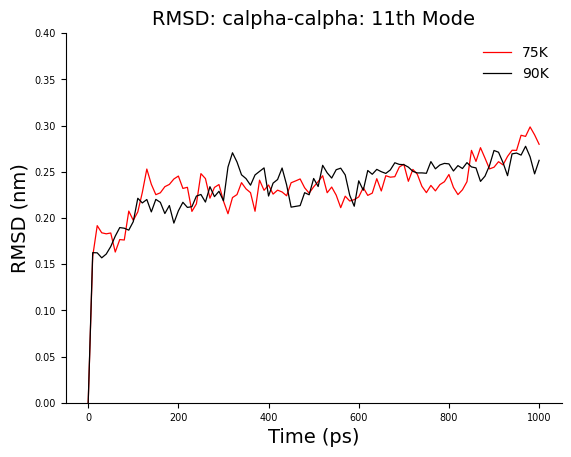

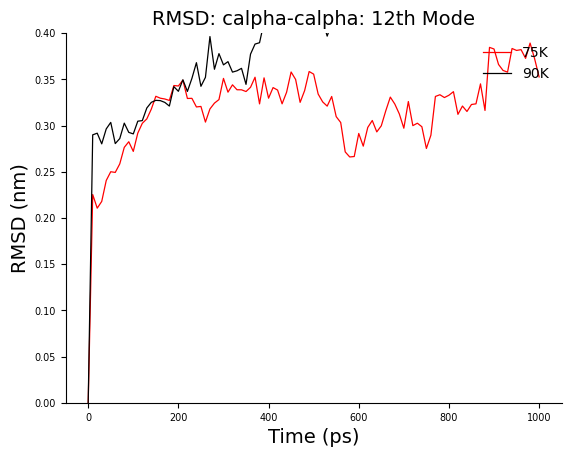

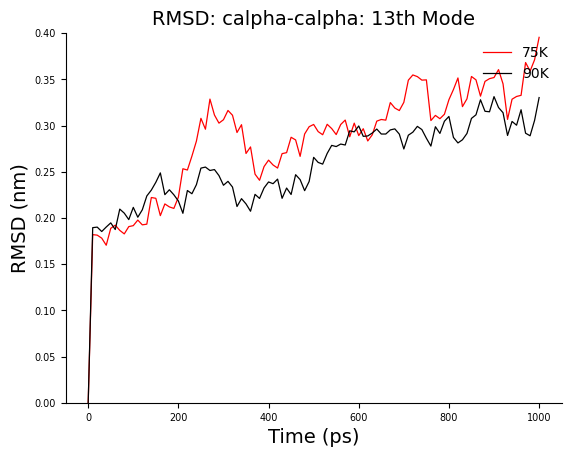

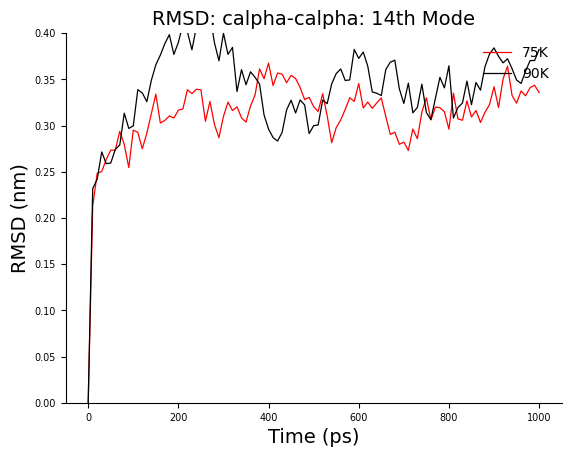

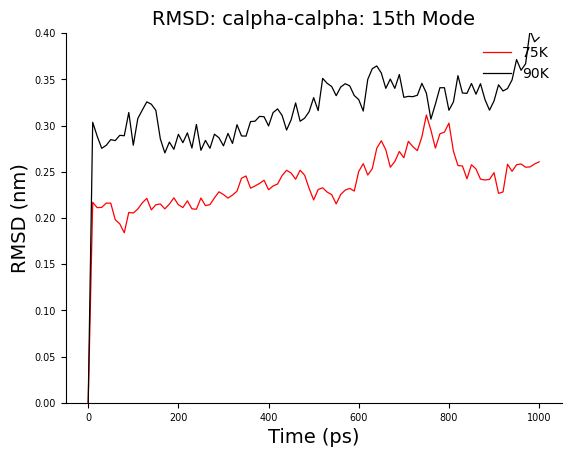

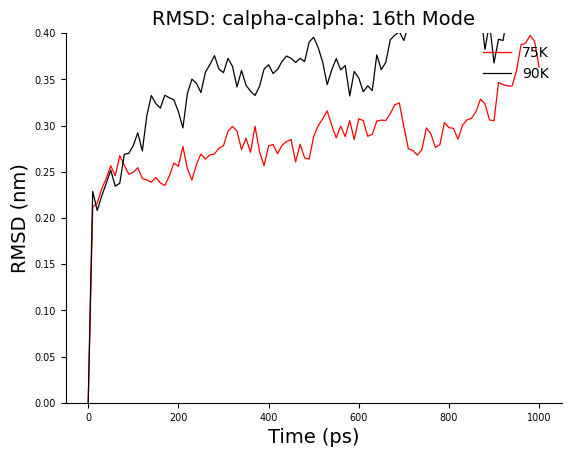

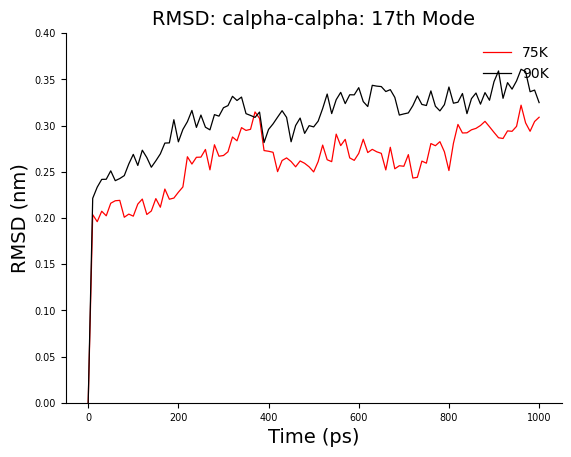

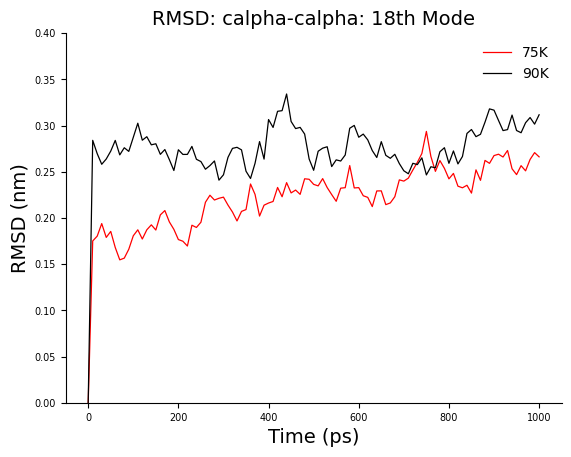

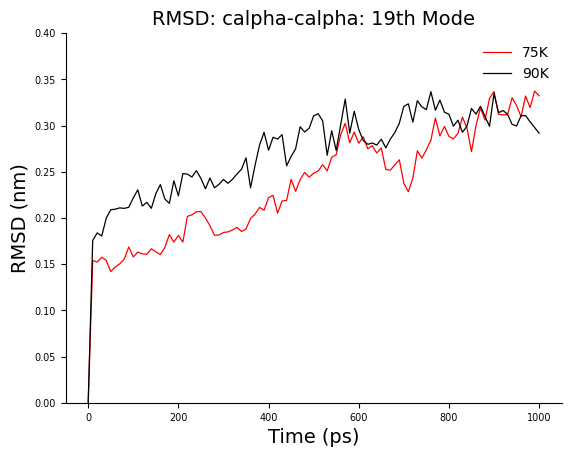

In [16]:
rmsdcc_75 = []
rmsdcc_90 = []

for i in range(20):
    filename = file_dir+"75_delT/{}_mode/rmsd_calpha_calpha.xvg".format(i)
    rmsd_75 = np.genfromtxt(filename, skip_header = 18)
    rmsdcc_75.append(rmsd_75[:, 1])
    filename = file_dir+"90_delT/{}_mode/rmsd_calpha_calpha.xvg".format(i)
    rmsd_90 = np.genfromtxt(filename, skip_header = 18)
    rmsdcc_90.append(rmsd_90[:, 1])
    plt.figure()
    ax = plt.subplot()
    plt.rc('font', family='sans-serif')
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    ax.plot(rmsd_75[:, 0], rmsd_75[:, 1], label = '75K', color = 'red', linewidth = 0.9)
    ax.plot(rmsd_90[:, 0], rmsd_90[:, 1], label = '90K', color = 'black', linewidth = 0.9)
    plt.xlabel("Time (ps)", fontsize = 14)
    plt.ylabel("RMSD (nm)", fontsize = 14)
    plt.ylim(0, 0.4)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title("RMSD: calpha-calpha: {}th Mode".format(i), fontsize = 14)
    plt.legend(frameon = False, loc ="upper right", ncol = 1, prop={'size':10})

Text(0.02, 0.5, 'RMSD (nm)')

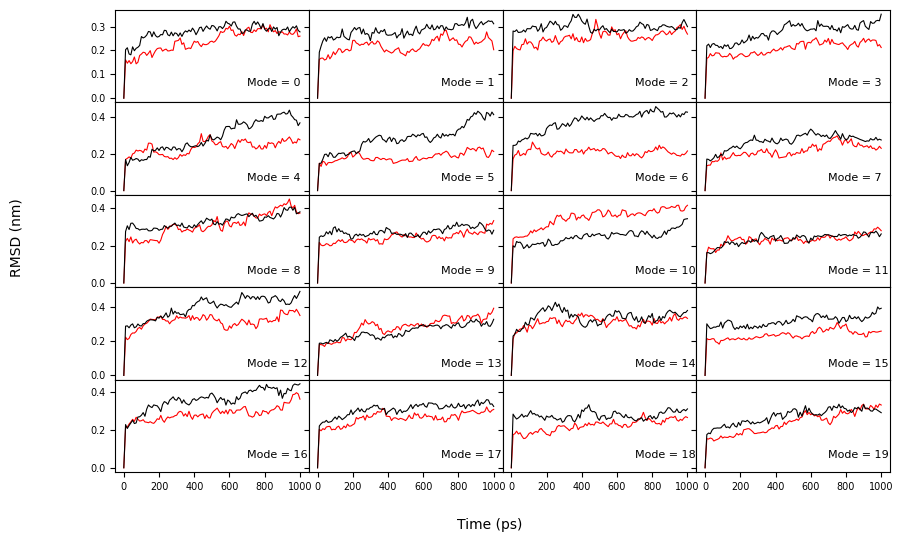

In [17]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, 4, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rmsdcc_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rmsdcc_90[j+i+lc], color = 'black', label = 'delT = 90K', linewidth=0.8)
        axes[i, j].text(700, 0.05, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
#        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD (nm)', fontsize = 10)

Text(0.02, 0.5, 'RMSD (nm)')

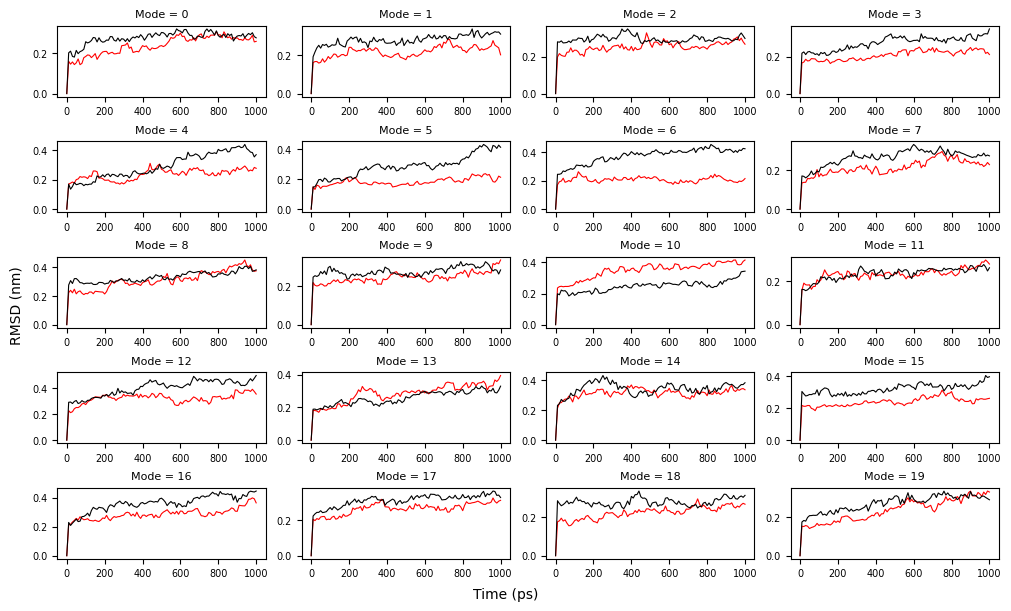

In [18]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rmsdcc_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rmsdcc_90[j+i+lc], color = 'black', label = 'delT = 90K', linewidth=0.8)
#        axes[i, j].legend(frameon = False, loc ="upper left", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.4)
        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD: calpha-calpha', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD (nm)', fontsize = 10)

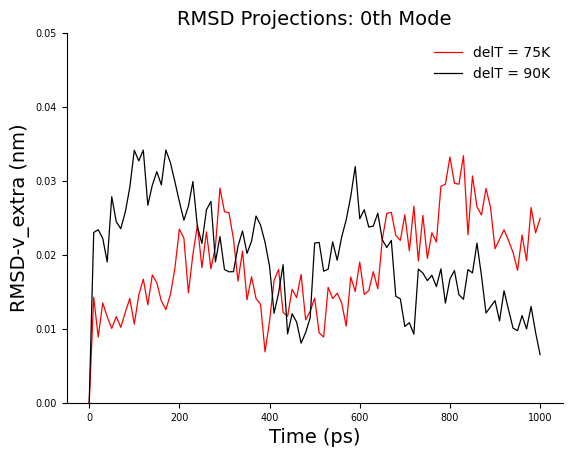

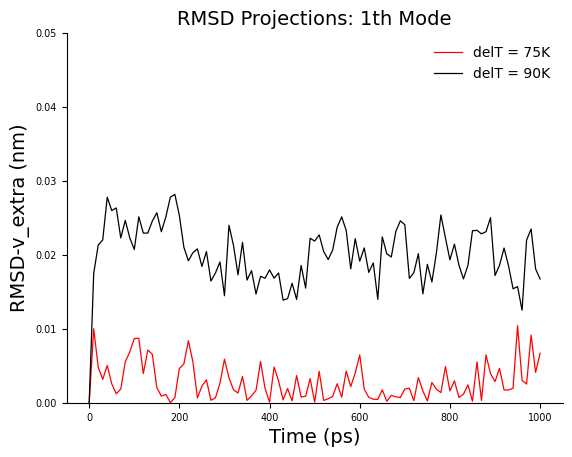

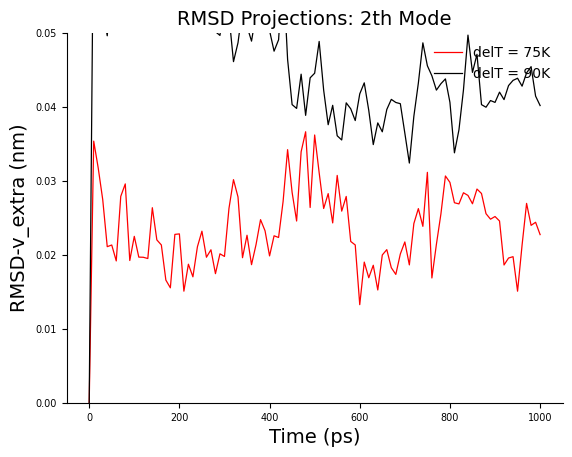

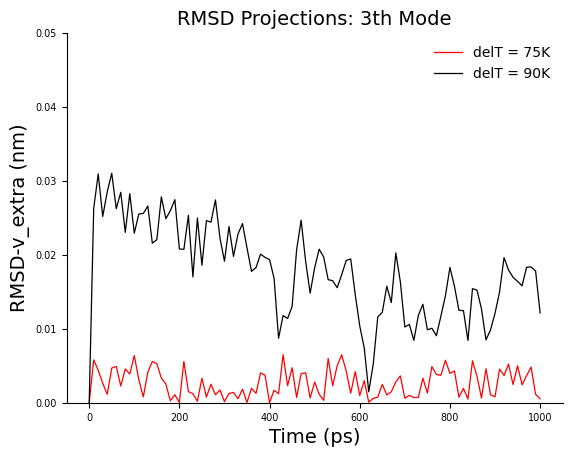

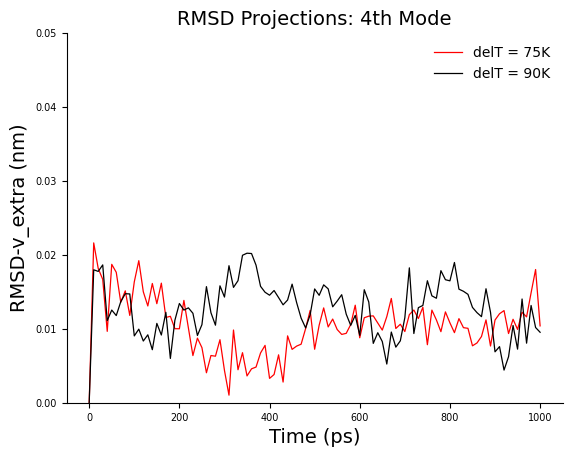

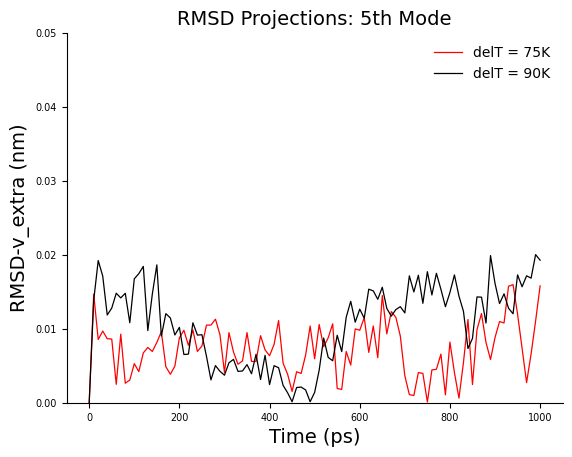

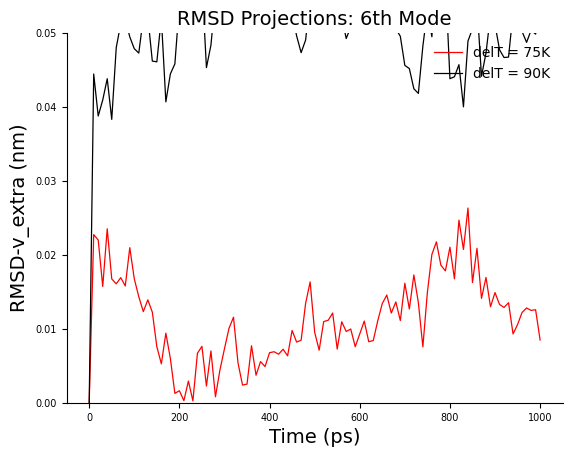

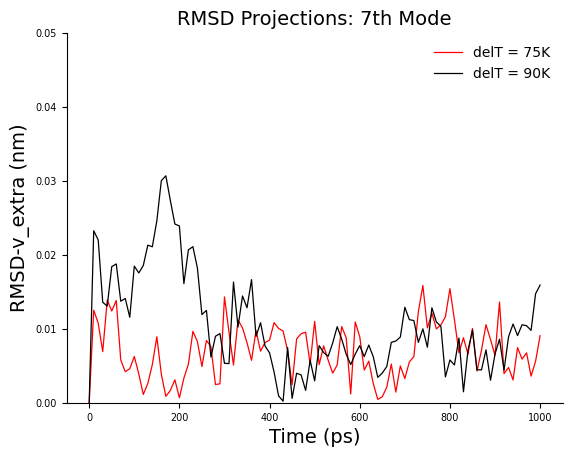

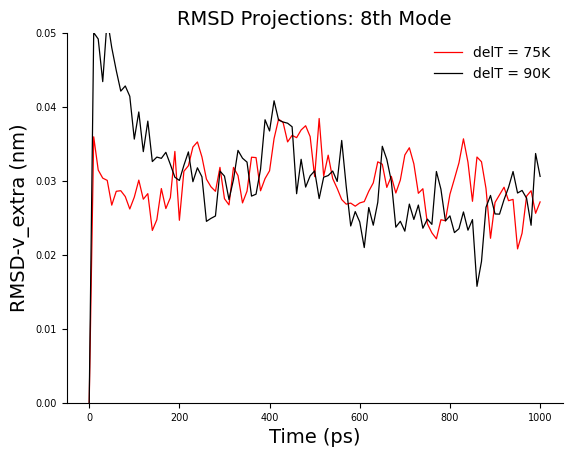

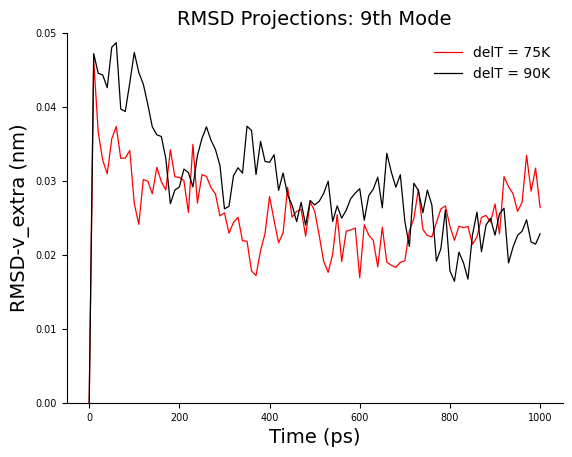

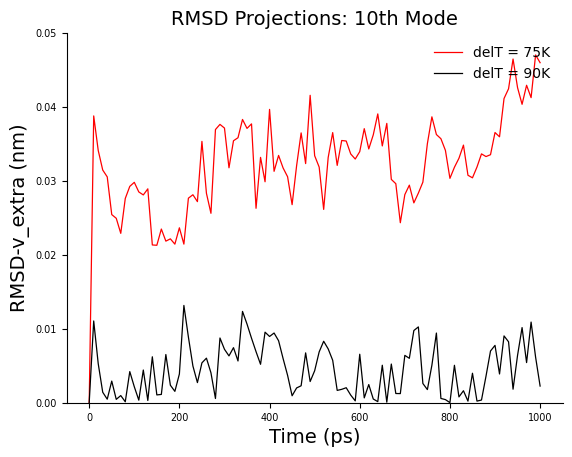

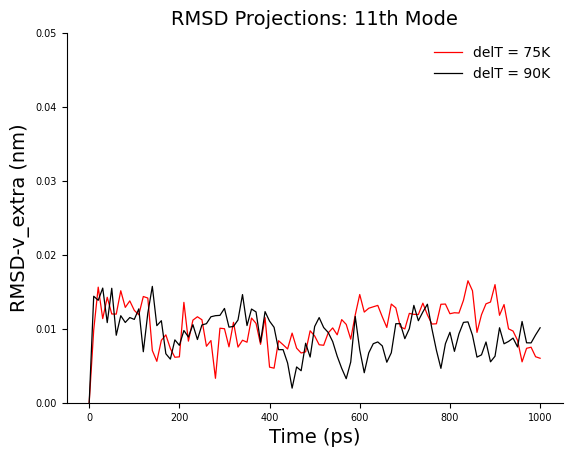

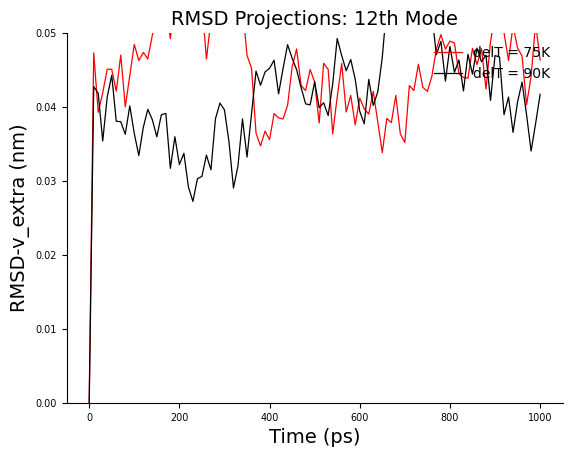

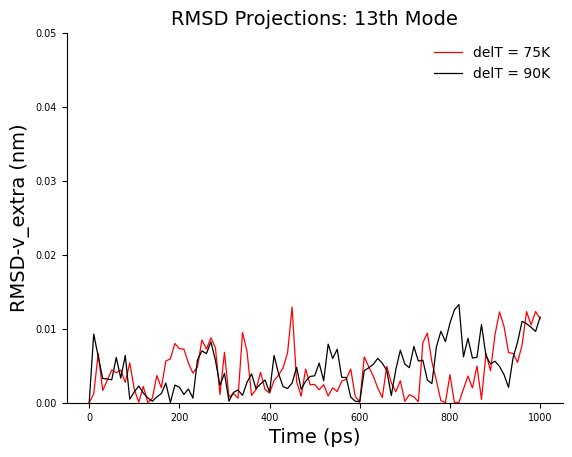

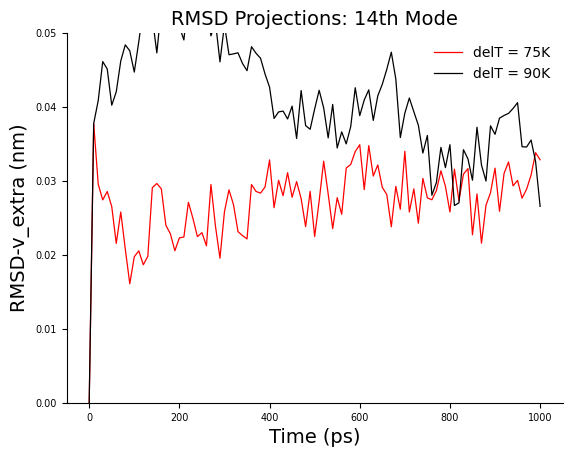

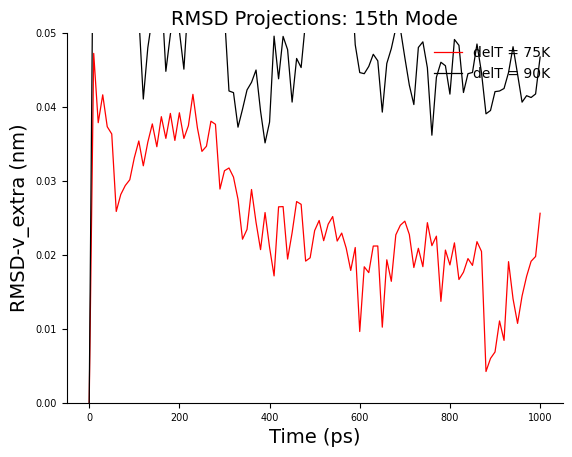

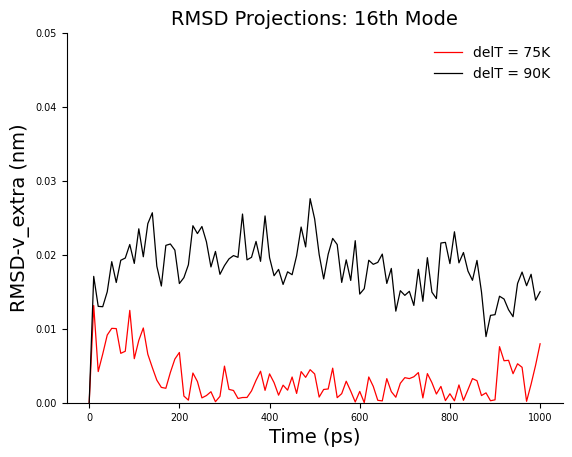

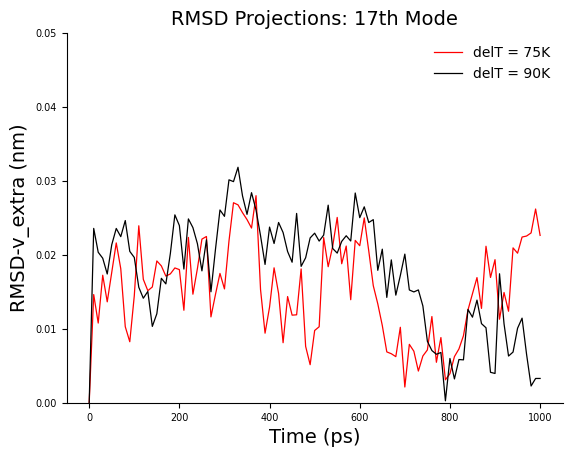

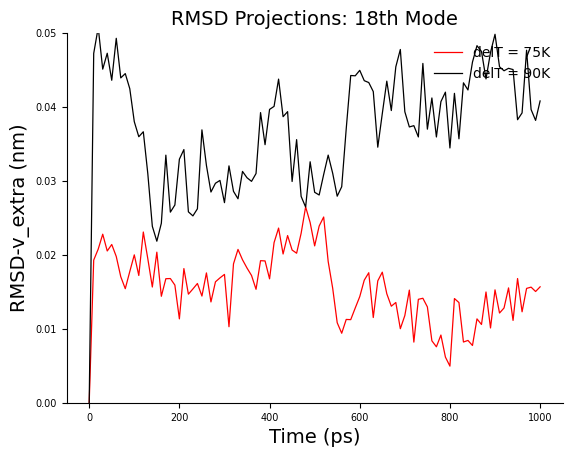

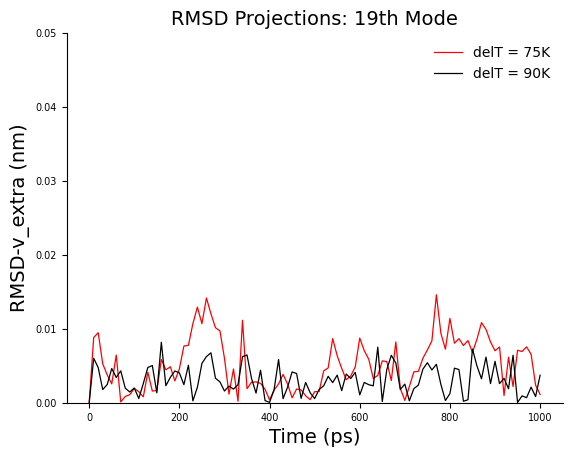

In [19]:
time = [i*10 for i in range(101)]

for i in range(20):
    fig, ax = plt.subplots()
    plt.rc('font', family='sans-serif')
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    ax.plot(time, rd_75[i], label = 'delT = 75K', color = 'red', linewidth = 0.9)
    ax.plot(time, rd_90[i], label = 'delT = 90K', color = 'black', linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':10})
    ax.set_xlabel('Time (ps)', fontsize = 14)
    ax.set_ylabel('RMSD-v_extra (nm)', fontsize = 14)
    ax.set_ylim(0, 0.05)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('RMSD Projections: {}th Mode'.format(i), fontsize = 14)
    plt.show()

Text(0.02, 0.5, 'RMSD-v_extra (nm)')

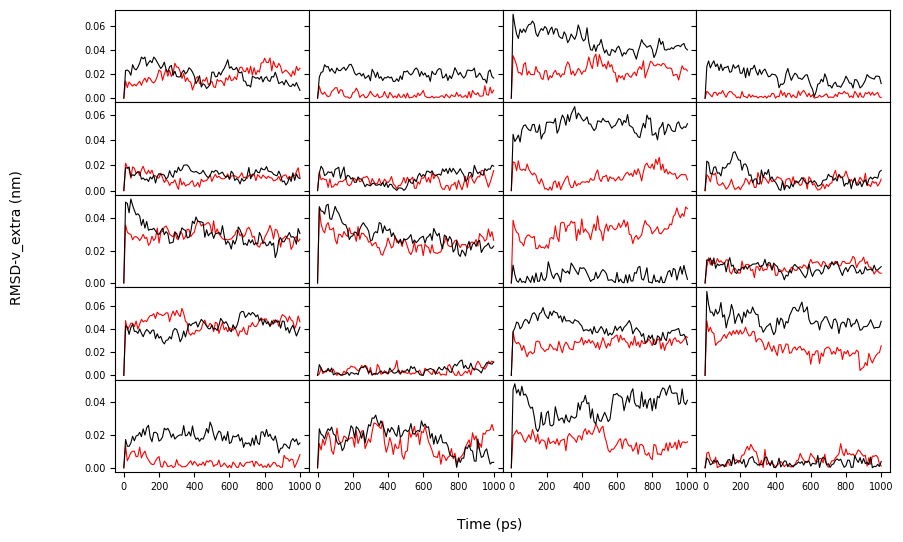

In [20]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
#fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, 4, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rd_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rd_90[j+i+lc], color = 'black', label = 'delT = 90K', linewidth=0.8)
#        axes[i, j].text(400, 0.035, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
#        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD-v_extra (nm)', fontsize = 10)

Text(0.02, 0.5, 'RMSD-v_extra (nm)')

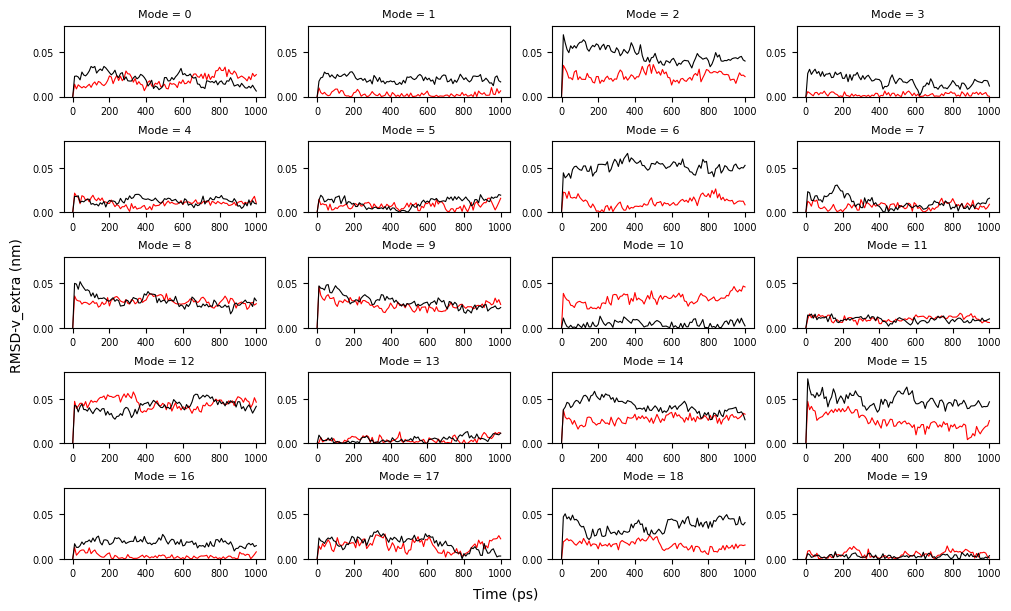

In [21]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rd_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rd_90[j+i+lc], color = 'black', label = 'delT = 90K', linewidth=0.8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
        axes[i, j].set_ylim(0, 0.08)
        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD-v_extra (nm)', fontsize = 10)

Text(0.5, 1.0, 'B')

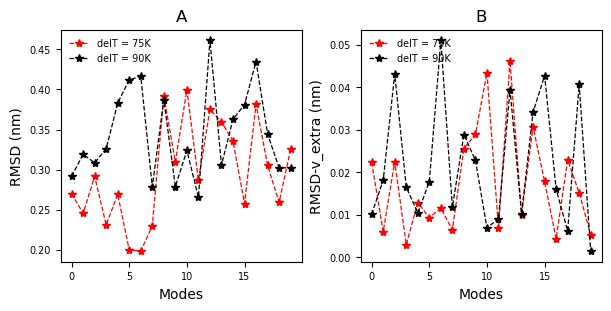

In [22]:
avg_rmsdcc_75 = []
avg_rmsdcc_90 = []
avg_rd_75 = []
avg_rd_90 = []
mode_lst = []
for k in range(20):
    avg_rmsdcc_75.append(np.average(rmsdcc_75[k][95:]))
    avg_rmsdcc_90.append(np.average(rmsdcc_90[k][95:]))
    avg_rd_75.append(np.average(rd_75[k][95:]))
    avg_rd_90.append(np.average(rd_90[k][95:]))
    mode_lst.append(k)
    

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

axes[0].plot(mode_lst, avg_rmsdcc_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
axes[0].plot(mode_lst, avg_rmsdcc_90, '*', linestyle='dashed', color = 'black', label = 'delT = 90K', linewidth = 0.9)
axes[0].legend(frameon = False, loc ="upper left", prop={'size':7})
axes[0].set_xlabel("Modes", fontsize = 10)
axes[0].set_ylabel("RMSD (nm)", fontsize = 10)
axes[0].set_title("A", fontsize = 12)
axes[1].plot(mode_lst, avg_rd_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
axes[1].plot(mode_lst, avg_rd_90, '*', linestyle='dashed', color = 'black', label = 'delT = 90K', linewidth = 0.9)
axes[1].legend(frameon = False, loc ="upper left", prop={'size':7})
axes[1].set_xlabel("Modes", fontsize = 10)
axes[1].set_ylabel("RMSD-v_extra (nm)", fontsize = 10)
axes[1].set_title("B", fontsize = 12)

    
# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(mode_lst, avg_rmsdcc_75, '*', linestyle='dashed', color = 'grey', label = 'delT = 75K')
# plt.plot(mode_lst, avg_rmsdcc_100, '*', linestyle='dashed', color = 'orange', label = 'delT = 100K')
# plt.xlabel("modes", fontsize = 14)
# plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
# plt.ylabel("RMSD (nm)", fontsize = 14)
# plt.title("Average RMSD for separate modes", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.legend(frameon = False, loc ="upper right", ncol = 1, prop={'size':10})

# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(mode_lst, avg_rd_75, '*', linestyle='dashed', color = 'grey', label = 'delT = 75K')
# plt.plot(mode_lst, avg_rd_100, '*', linestyle='dashed', color = 'orange', label = 'delT = 100K')
# plt.xlabel("modes", fontsize = 14)
# plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
# plt.ylabel("RMSD-v_extra (nm)", fontsize = 14)
# plt.title("Average RMSD projections for separate modes", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.legend(frameon = False, loc ="upper left", ncol = 1, prop={'size':10})

Text(0.02, 0.5, 'RMSF (nm)')

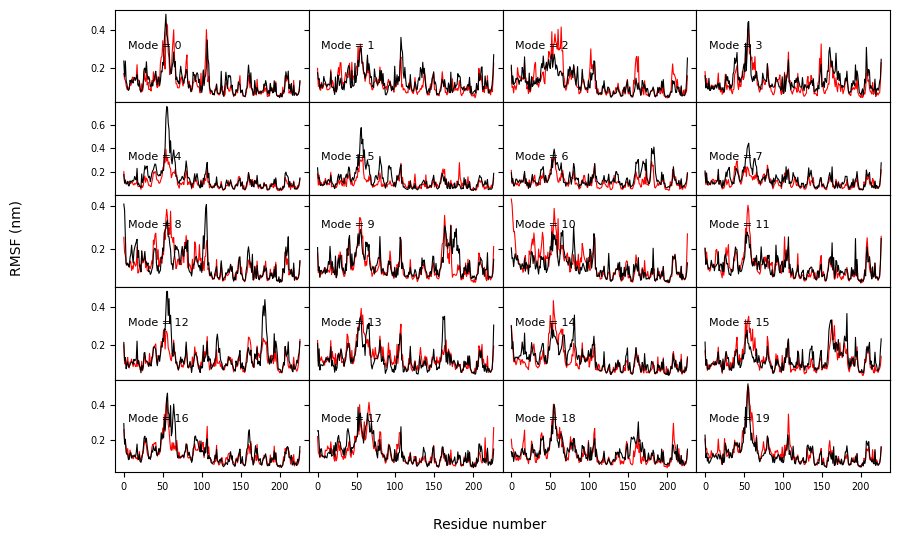

In [23]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
#fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, 4, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        rmsf_L = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_75 = np.hstack((rmsf_L, rmsf_H))
        rmsf_L = np.genfromtxt(file_dir+"90_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt(file_dir+"90_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_90 = np.hstack((rmsf_L, rmsf_H))
        axes[i, j].plot(range(227), rmsf_75, color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(range(227), rmsf_90, color = 'black', label = 'delT = 90K', linewidth=0.8)
        axes[i, j].text(5, 0.3, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
#        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Residue number', fontsize = 10)
fig.supylabel('RMSF (nm)', fontsize = 10)

Text(0.02, 0.5, 'RMSF (nm)')

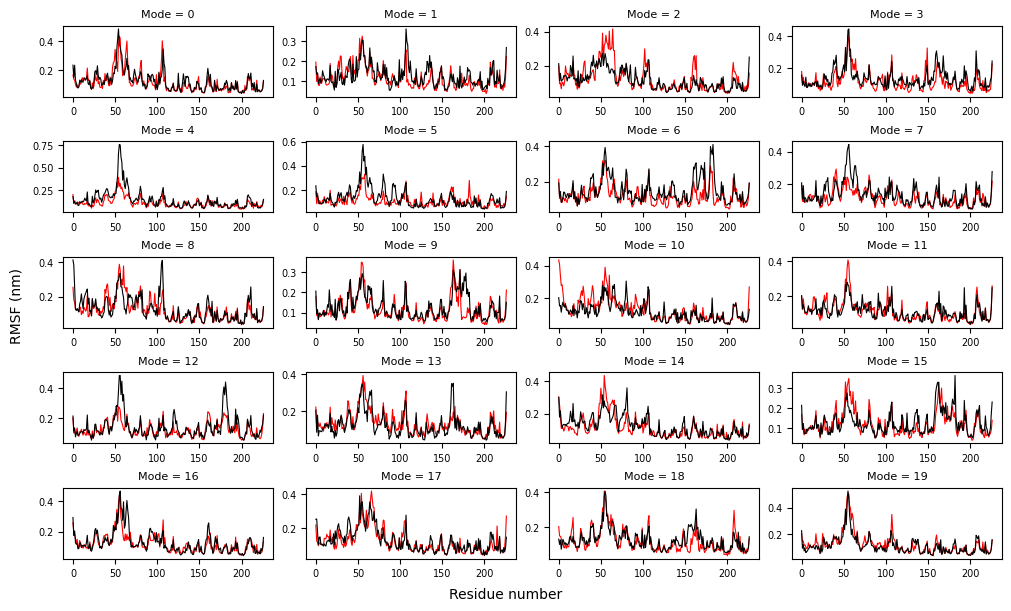

In [24]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        rmsf_L = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_75 = np.hstack((rmsf_L, rmsf_H))
        rmsf_L = np.genfromtxt(file_dir+"90_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt(file_dir+"90_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_90 = np.hstack((rmsf_L, rmsf_H))
        axes[i, j].plot(range(227), rmsf_75, color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(range(227), rmsf_90, color = 'black', label = 'delT = 90K', linewidth=0.8)
#        axes[i, j].text(5, 0.3, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Residue number', fontsize = 10)
fig.supylabel('RMSF (nm)', fontsize = 10)

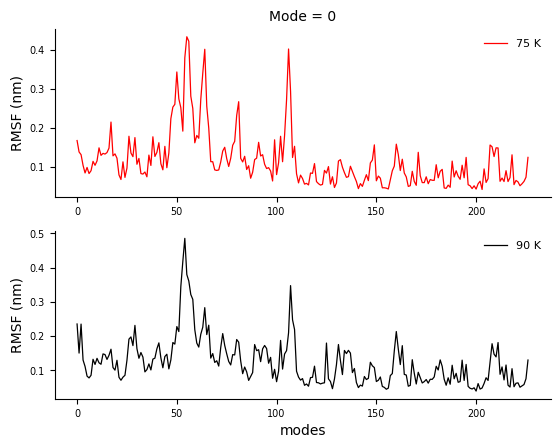

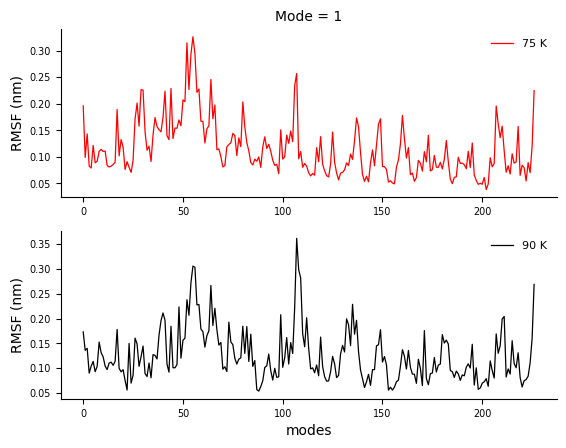

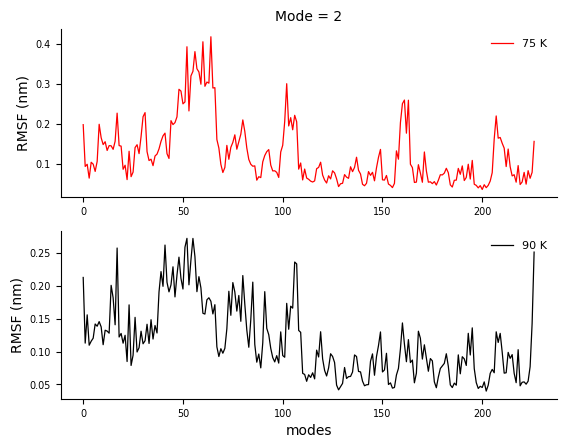

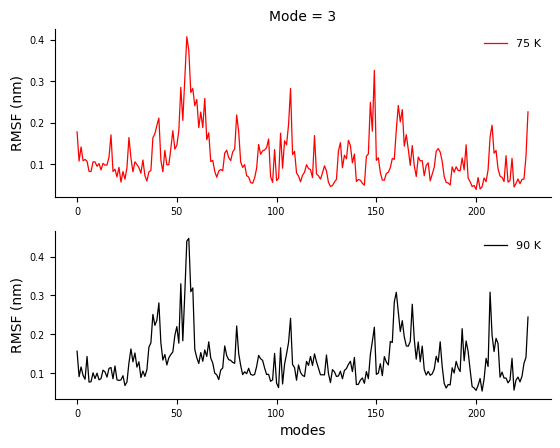

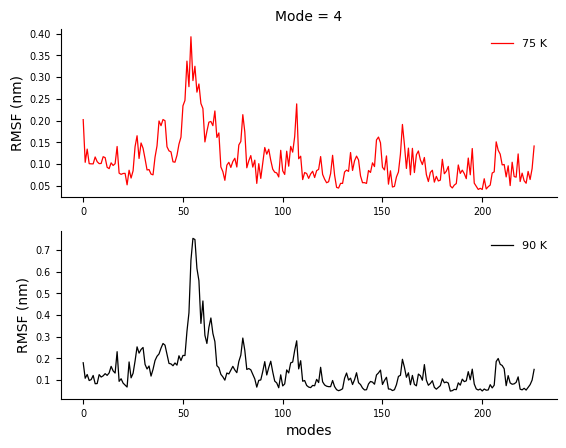

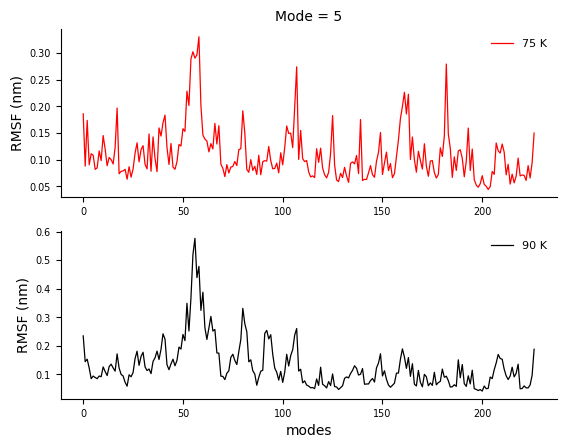

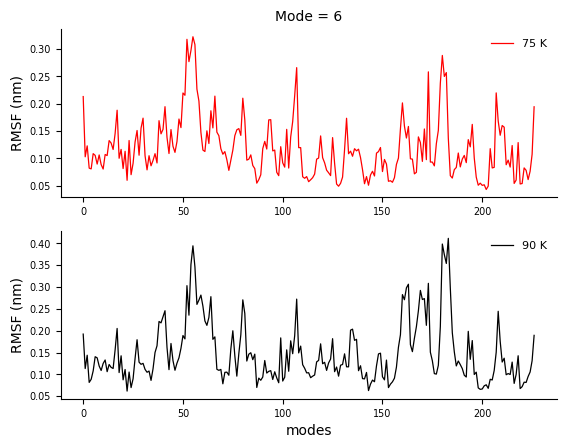

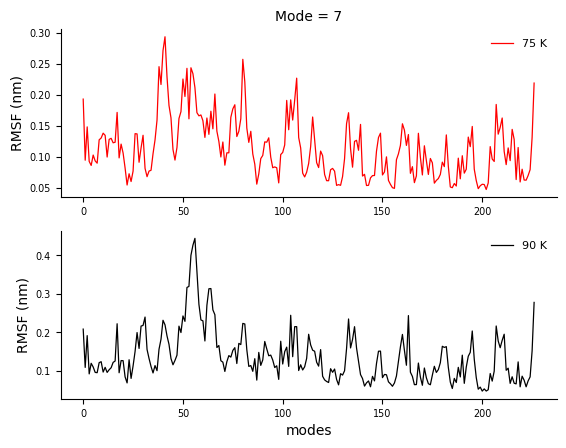

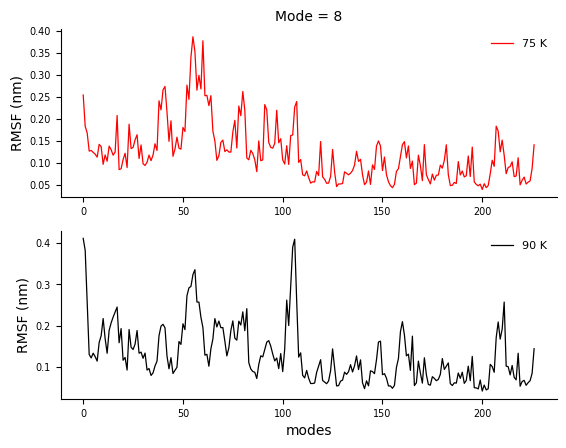

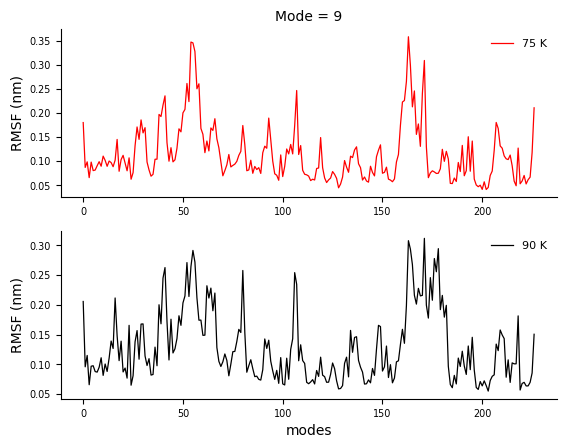

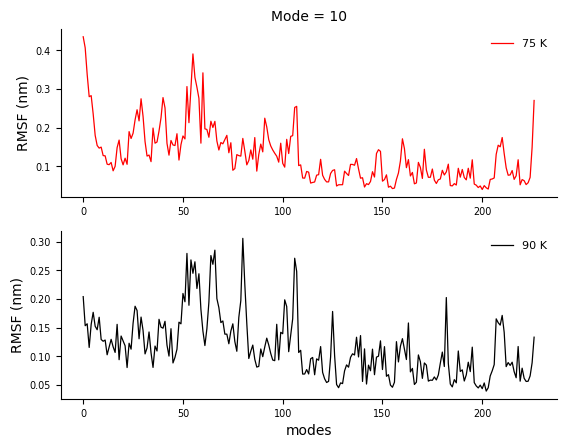

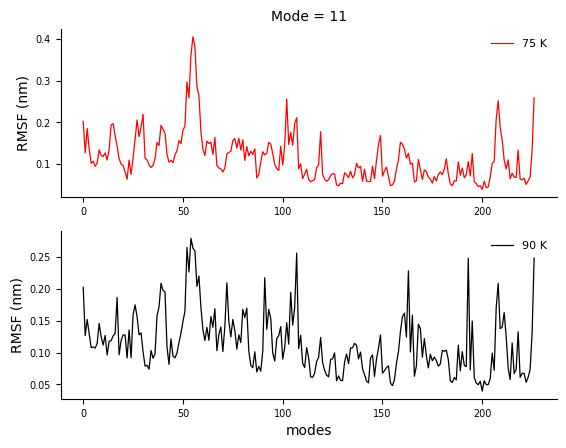

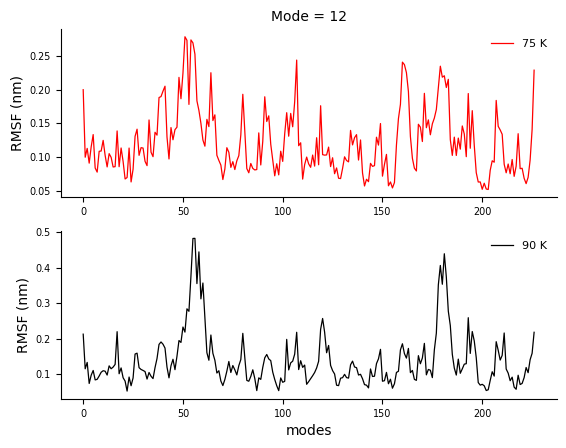

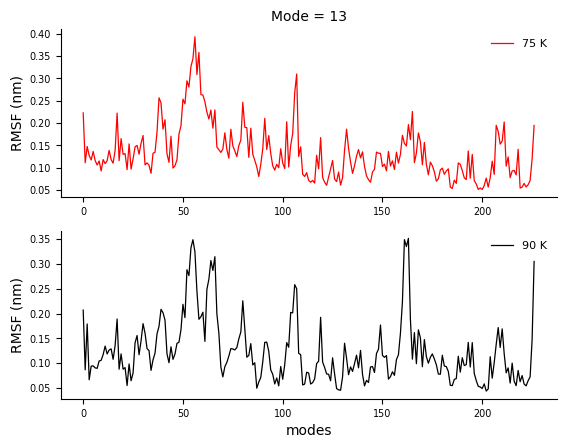

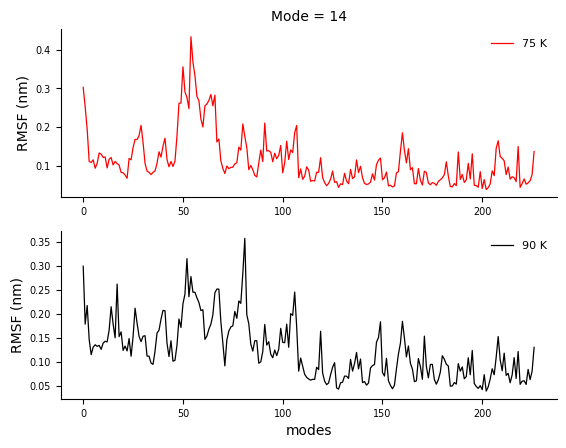

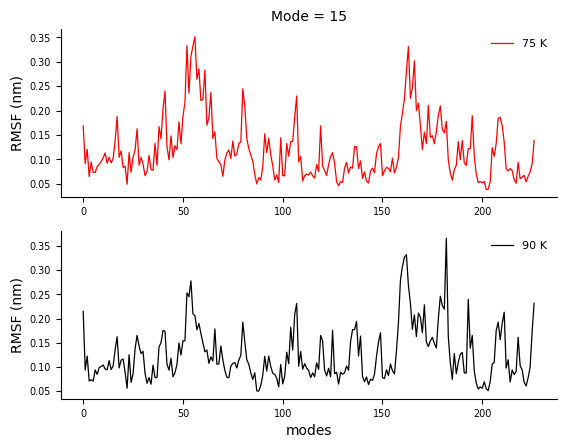

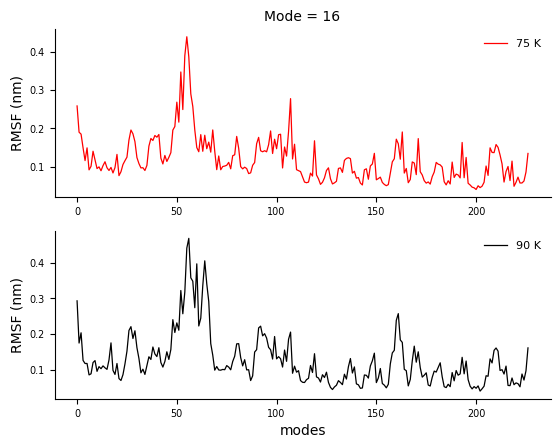

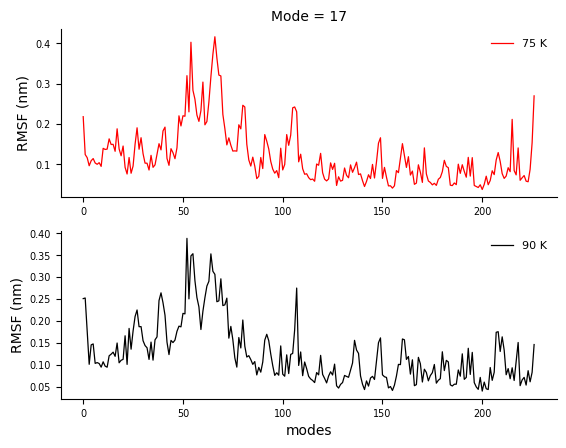

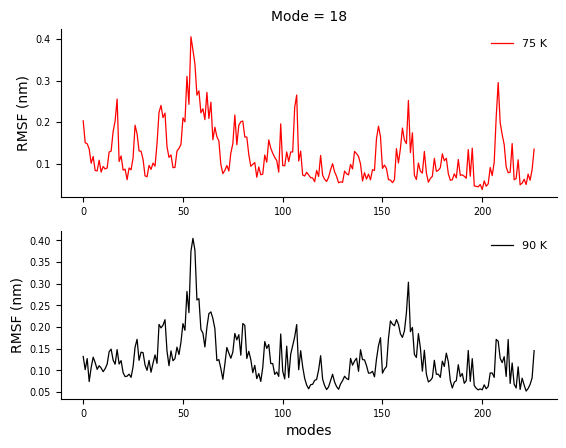

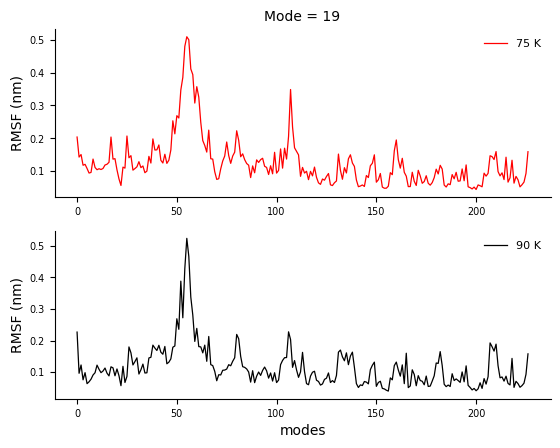

In [25]:
for i in range(20):
    rmsf_L = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chL.xvg".format(i), skip_header = 17)[:, 1]
    rmsf_H = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chH.xvg".format(i), skip_header = 17)[:, 1]
    rmsf_75 = np.hstack((rmsf_L, rmsf_H))
    rmsf_L = np.genfromtxt(file_dir+"90_delT/{}_mode/rmsf_chL.xvg".format(i), skip_header = 17)[:, 1]
    rmsf_H = np.genfromtxt(file_dir+"90_delT/{}_mode/rmsf_chH.xvg".format(i), skip_header = 17)[:, 1]
    rmsf_90 = np.hstack((rmsf_L, rmsf_H))
    fig, axes = plt.subplots(nrows=2,ncols=1)
    plt.rc('font', family='sans-serif')
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    axes[0].plot(rmsf_75, color = 'red', label = '75 K', linewidth = 0.9)
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[0].set_ylabel("RMSF (nm)", fontsize = 10)
    axes[0].set_title("Mode = {}".format(i), fontsize = 10)
    axes[0].legend(frameon = False,loc ="upper right", prop={'size':8})
    axes[1].plot(rmsf_90, color = 'black', label = '90 K', linewidth = 0.9)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1].set_xlabel("modes", fontsize = 10)
    axes[1].set_ylabel("RMSF (nm)", fontsize = 10)

#### delT = 75; Finding the alpha

In [26]:
wm = v[6:26]
Um = U_m[6:26]
m = len(Um)
alpha = np.random.rand(m, 1)

In [27]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_75, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_75[i][95:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_75, m)}

1.371142782646828e-12
[0.14341432 0.01816738 0.04423414 0.0049292  0.02061343 0.01376905
 0.01404992 0.00678013 0.02117964 0.02277642 0.03289258 0.00462619
 0.02822573 0.00597746 0.01703154 0.00906557 0.00213446 0.01094464
 0.00708237 0.002177  ]
1.3364725992559556e-12
[0.43025403 0.05473175 0.13269575 0.0147329  0.06187655 0.04134199
 0.04217887 0.02030659 0.06353168 0.06832691 0.09866871 0.01386089
 0.08463725 0.01790457 0.05106497 0.02720368 0.00644682 0.0328528
 0.02129258 0.00655904]
1.5558880572807965e-11
[0.71702835 0.09128757 0.22114126 0.02454644 0.10312263 0.0689251
 0.07028843 0.03385206 0.10587926 0.11388754 0.16444181 0.02311752
 0.14107372 0.02984702 0.08510969 0.04534831 0.01076387 0.05477096
 0.03549475 0.01093739]


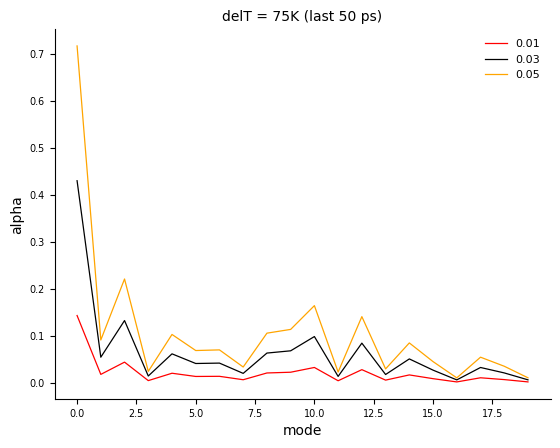

In [28]:
lst = [0.01, 0.03, 0.05]
alpha_75_5 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_75 = result.x
#    alpha_m_75 = alpha_m_75/np.linalg.norm(alpha_m_75)
    alpha_75_5.append(alpha_m_75)
    print(constraint(alpha_m_75, rd_75, m))
    print(alpha_m_75)
#     plt.plot(alpha_m_75, label = str(i))
#     plt.title("delT = 75 (last 50 ps)")
#     plt.xlabel("mode")
#     plt.ylabel("alpha")
#     plt.legend(loc ="upper right", ncol = 1, prop={'size':10})
    ax.plot(alpha_m_75, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 75K (last 50 ps)", fontsize = 10)
plt.show()

In [29]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_75, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_75[i][80:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_75, m)}

2.4520732666566403e-12
[0.15339213 0.01004952 0.0460431  0.00469188 0.01669472 0.01242594
 0.01786476 0.00758696 0.02233767 0.0194609  0.02711818 0.00716304
 0.02742216 0.00354952 0.01526559 0.00762486 0.00143013 0.00731752
 0.00551459 0.00271041]
6.795019408256664e-12
[0.46056207 0.03074101 0.13827594 0.01389774 0.04986123 0.03747582
 0.05357028 0.0229183  0.06706945 0.05854825 0.08087506 0.02123302
 0.08216437 0.01077958 0.04587211 0.02290352 0.00433367 0.0219561
 0.01663543 0.00810858]
-1.5135025177581696e-11
[0.76759343 0.05126233 0.23048096 0.0231591  0.08307873 0.06251515
 0.08924958 0.03820031 0.11176191 0.09757835 0.13479096 0.03539999
 0.13694122 0.01797536 0.07645727 0.03817818 0.00723075 0.03659956
 0.02772903 0.01351488]


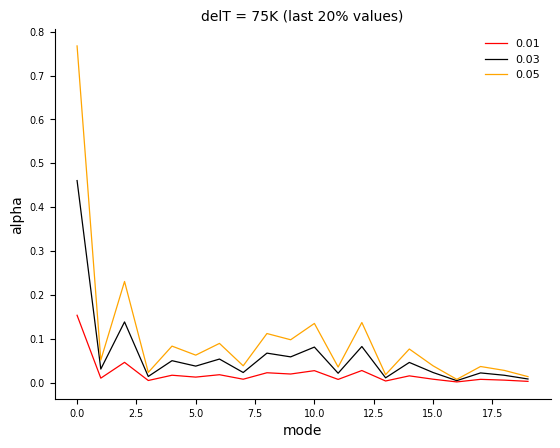

In [30]:
lst = [0.01, 0.03, 0.05]
alpha_75_20 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_75 = result.x
    alpha_75_20.append(alpha_m_75)
    print(constraint(alpha_m_75, rd_75, m))
    print(alpha_m_75)
    ax.plot(alpha_m_75, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 75K (last 20% values)", fontsize = 10)
plt.show()

#### delT = 100; Finding the alpha

In [31]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_90, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_90[i][95:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_90, m)}

0.020841645944556366
[0.04483056 0.03837097 0.05890569 0.01909041 0.01151905 0.01828616
 0.04314556 0.00861642 0.0166132  0.01244245 0.0036187  0.00421782
 0.01668913 0.00419241 0.0130907  0.01509526 0.00549193 0.00196052
 0.01316421 0.0003649 ]
0.18757401332671744
[0.13452836 0.1151477  0.17663887 0.05727462 0.03457505 0.05487058
 0.12935729 0.02587555 0.04977328 0.03734607 0.01085491 0.01264095
 0.05007112 0.01268391 0.03929592 0.04527829 0.0165868  0.00605528
 0.03955663 0.00116308]
0.5210387709849965
[0.22422696 0.19192431 0.29437181 0.09545879 0.05763098 0.09145497
 0.21556875 0.04313472 0.08293319 0.06224993 0.01809042 0.02106384
 0.08345297 0.02117526 0.06550173 0.07546139 0.02768189 0.01015026
 0.06594916 0.0019613 ]


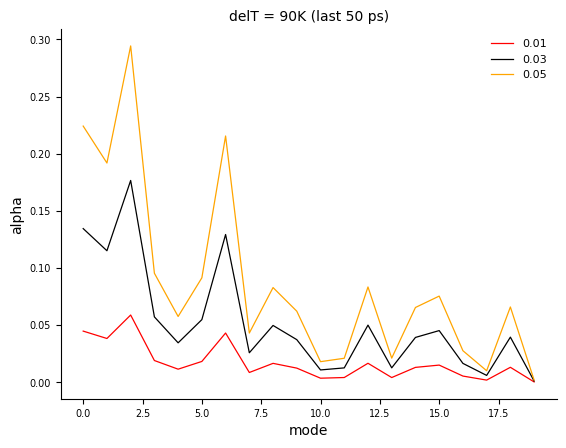

In [32]:
lst = [0.01, 0.03, 0.05]
alpha_90_5 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_90 = result.x
    alpha_90_5.append(alpha_m_90)
    print(argmin(alpha_m_90, wm))
    print(alpha_m_90)
    ax.plot(alpha_m_90, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 90K (last 50 ps)", fontsize = 10)
plt.show()

In [33]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_100, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_90[i][80:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_90, m)}

0.020669951227476353
[0.05991842 0.04122637 0.05716913 0.01692422 0.01273675 0.015098
 0.04080887 0.00576129 0.0148901  0.01183958 0.00237041 0.00388605
 0.01806638 0.00326988 0.01306169 0.01532519 0.00535293 0.00249633
 0.01384611 0.00081672]
0.1860280901200593
[0.17991838 0.12370847 0.1713965  0.05080391 0.03823103 0.04529544
 0.12235034 0.0173273  0.04458882 0.03556497 0.0070718  0.01178212
 0.05414339 0.0099261  0.03919991 0.0459464  0.01620299 0.00771488
 0.04159999 0.00253771]
0.5167443947701726
[0.29992028 0.20619069 0.28562285 0.08468368 0.06372554 0.07549334
 0.2038907  0.02889356 0.07428736 0.0592899  0.01177546 0.01967853
 0.09021906 0.01658211 0.0653393  0.0765679  0.02705428 0.01293509
 0.06935457 0.00425928]


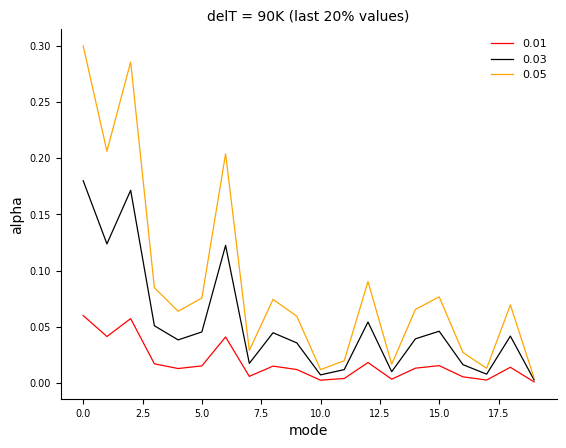

In [34]:
lst = [0.01, 0.03, 0.05]
alpha_90_20 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_90 = result.x
    alpha_90_20.append(alpha_m_90)
    print(argmin(alpha_m_90, wm))
    print(alpha_m_90)
    ax.plot(alpha_m_90, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 90K (last 20% values)", fontsize = 10)
plt.show()

Text(0.02, 0.5, 'alpha')

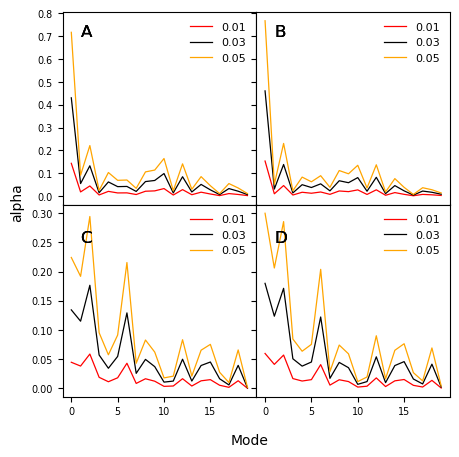

In [35]:
#fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), layout='constrained')
fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for i in range(3):
    axes[0, 0].plot(mode_lst, alpha_75_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[0, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[0, 0].text(1, 0.7, "A", fontsize = 12)
    axes[0, 1].plot(mode_lst, alpha_75_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[0, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[0, 1].text(1, 0.7, "B", fontsize = 12)
    axes[1, 0].plot(mode_lst, alpha_90_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[1, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 0].text(1, 0.25, "C", fontsize = 12)
    axes[1, 1].plot(mode_lst, alpha_90_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[1, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 1].text(1, 0.25, "D", fontsize = 12)
#fig.suptitle('Normal mode coefficients', fontsize = 14)
fig.supxlabel('Mode', fontsize = 10)
fig.supylabel('alpha', fontsize = 10)

Text(0.02, 0.5, 'alpha')

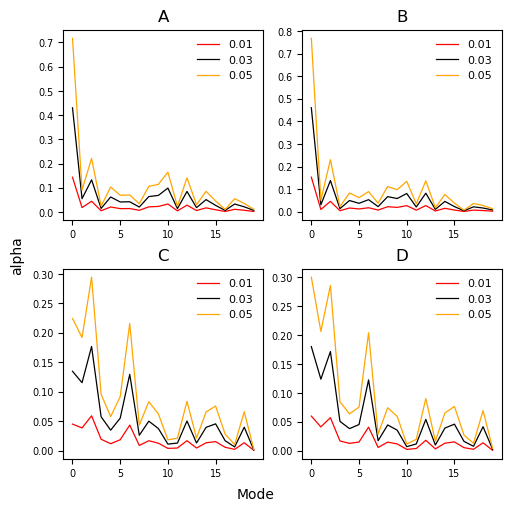

In [36]:
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for i in range(3):
    axes[0, 0].plot(mode_lst, alpha_75_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
#    axes[0, 0].set_ylim(0, 1.0)
    axes[0, 0].set_title('A', fontsize = 12)
    axes[0, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[0, 1].plot(mode_lst, alpha_75_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
#    axes[0, 1].set_ylim(0, 1.0)
    axes[0, 1].set_title('B', fontsize = 12)
    axes[0, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 0].plot(mode_lst, alpha_90_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
#    axes[1, 0].set_ylim(0, 1.0)
    axes[1, 0].set_title('C', fontsize = 12)
    axes[1, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 1].plot(mode_lst, alpha_90_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
#    axes[1, 1].set_ylim(0, 1.0)
    axes[1, 1].set_title('D', fontsize = 12)
    axes[1, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
#fig.suptitle('Normal mode coefficients', fontsize = 14)
fig.supxlabel('Mode', fontsize = 10)
fig.supylabel('alpha', fontsize = 10)

In [37]:
d_75_5 = np.zeros((3, Um[0].shape[0]))
d_75_20 = np.zeros((3, Um[0].shape[0]))
d_90_5 = np.zeros((3, Um[0].shape[0]))
d_90_20 = np.zeros((3, Um[0].shape[0]))
for i in range(m):
    for j in range(3):
        d_75_5[j] += alpha_75_5[j][i]*Um[i]
        d_75_20[j] += alpha_75_20[j][i]*Um[i]
        d_90_5[j] += alpha_90_5[j][i]*Um[i]
        d_90_20[j] += alpha_90_20[j][i]*Um[i]
        d_75_5[j] = d_75_5[j]/np.linalg.norm(d_75_5[j])
        d_75_20[j] = d_75_20[j]/np.linalg.norm(d_75_20[j])
        d_90_5[j] = d_90_5[j]/np.linalg.norm(d_90_5[j])
        d_90_20[j] = d_90_20[j]/np.linalg.norm(d_90_20[j])

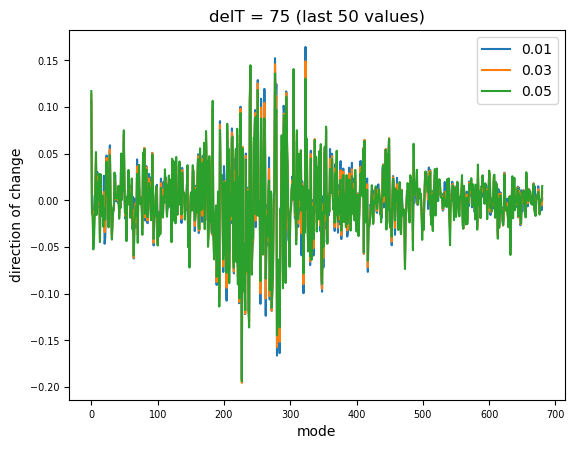

In [38]:
xi_lst = [0.01, 0.03, 0.05]
for i in range(3):
    plt.plot(d_75_5[i], label = str(xi_lst[i]))
    plt.title("delT = 75 (last 50 values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

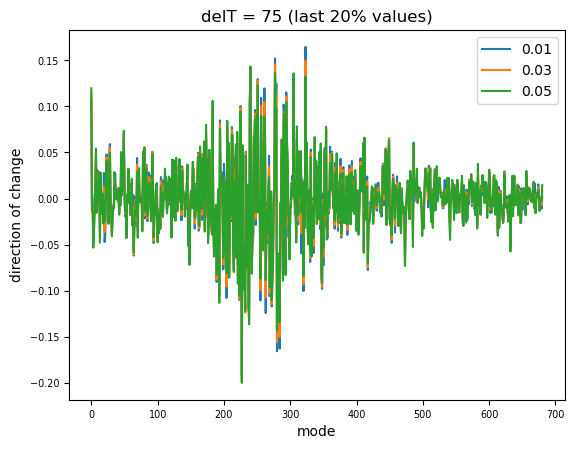

In [39]:
for i in range(3):
    plt.plot(d_75_20[i], label = str(xi_lst[i]))
    plt.title("delT = 75 (last 20% values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

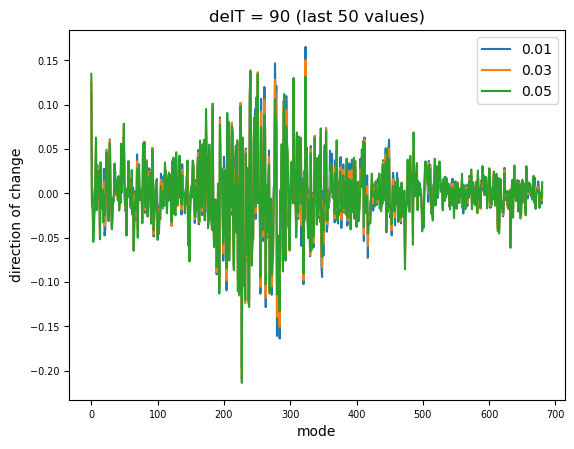

In [40]:
for i in range(3):
    plt.plot(d_90_5[i], label = str(xi_lst[i]))
    plt.title("delT = 90 (last 50 values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

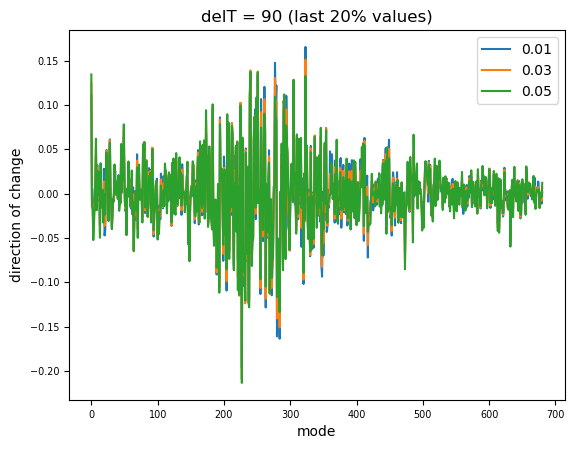

In [41]:
for i in range(3):
    plt.plot(d_90_20[i], label = str(xi_lst[i]))
    plt.title("delT = 90 (last 20% values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

In [42]:
all_d = []
for i in range(3):
    all_d.append(d_75_5[i])
for i in range(3):
    all_d.append(d_75_20[i])
for i in range(3):
    all_d.append(d_90_5[i])
for i in range(3):
    all_d.append(d_90_20[i])

In [43]:
dot_product = np.zeros((len(all_d), len(all_d)))
for i in range(len(all_d)):
    for j in range(len(all_d)):
        dot_product[i, j] = np.dot(all_d[i], all_d[j])

In [44]:
dot_product

array([[1.        , 0.98710919, 0.95016998, 0.99990947, 0.98904759,
        0.95674694, 0.99846517, 0.97568356, 0.92205248, 0.99850123,
        0.97685889, 0.92546916],
       [0.98710919, 1.        , 0.98780535, 0.98609573, 0.99921295,
        0.99007349, 0.9849282 , 0.98665963, 0.95631491, 0.98466728,
        0.98696653, 0.95841284],
       [0.95016998, 0.98780535, 1.        , 0.94826997, 0.98434262,
        0.99794446, 0.9472457 , 0.97244135, 0.96523205, 0.94670526,
        0.97190279, 0.96600114],
       [0.99990947, 0.98609573, 0.94826997, 1.        , 0.988567  ,
        0.95570367, 0.99860429, 0.97536151, 0.92131462, 0.99860743,
        0.97644139, 0.92458099],
       [0.98904759, 0.99921295, 0.98434262, 0.988567  , 1.        ,
        0.98915016, 0.98757313, 0.98798188, 0.95636905, 0.98721491,
        0.98800902, 0.95803016],
       [0.95674694, 0.99007349, 0.99794446, 0.95570367, 0.98915016,
        1.        , 0.95498814, 0.97816262, 0.96889338, 0.9542892 ,
        0.97717216,

## 3. Friction matrix 

In [45]:
# saving after every 0.001 seconds, simulation length = 200ps
vel = np.loadtxt(file_dir+"vel.xvg", comments=["@", "#"], unpack=True)
time = vel[0]
vel = vel[1:]

In [46]:
len(vel[0])

200001

In [47]:
vel_x = np.zeros((len(time), n_res))
vel_y = np.zeros((len(time), n_res))
vel_z = np.zeros((len(time), n_res))
for j in range(len(time)):
    vel_xx = []
    vel_yy = []
    vel_zz = []
    for i in range(0, n_res):
        vel_xx.append(vel[i*3+0][j])
        vel_yy.append(vel[i*3+1][j])
        vel_zz.append(vel[i*3+2][j])
    vel_x[j] = vel_xx
    vel_y[j] = vel_yy
    vel_z[j] = vel_zz

In [48]:
# Compute omega and initialize velocity array
n_l = n_res
m_l = n_l * 3
n = len(time)
velocity = np.zeros((m_l, n))
velocity[0:m_l:3, :] = vel_x.T
velocity[1:m_l:3, :] = vel_y.T
velocity[2:m_l:3, :] = vel_z.T

# Compute correlation function
cvv = np.zeros((11, m_l), dtype=np.float32)
for frame_diff in range(0, 11):
    velacc = np.zeros((1, m_l), dtype=np.float32)
    ind = 0
    for frame in range(199991):
        ind += 1
        velacc += np.transpose(velocity[:, frame] * velocity[:, frame + frame_diff])
    velacc /= ind
    cvv[frame_diff, :] = velacc[0]

Text(0, 0.5, 'Cvv matrix values')

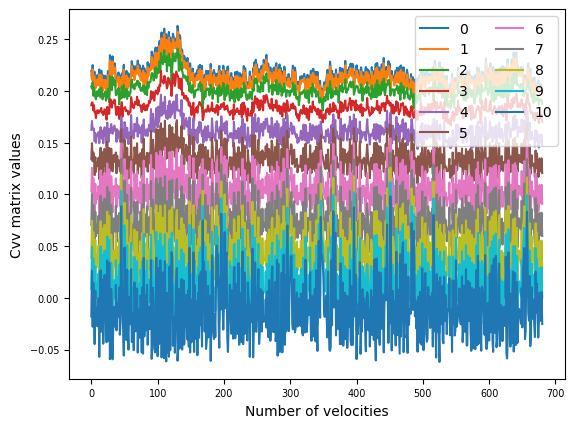

In [49]:
for i in range(11):
    plt.plot(cvv[i], label = str(i))
#plt.title("Cvv matrix")
plt.legend(loc ="upper right", ncol = 2, prop={'size':10})
plt.xlabel("Number of velocities")
plt.ylabel("Cvv matrix values")

Text(0, 0.5, 'Cvv values')

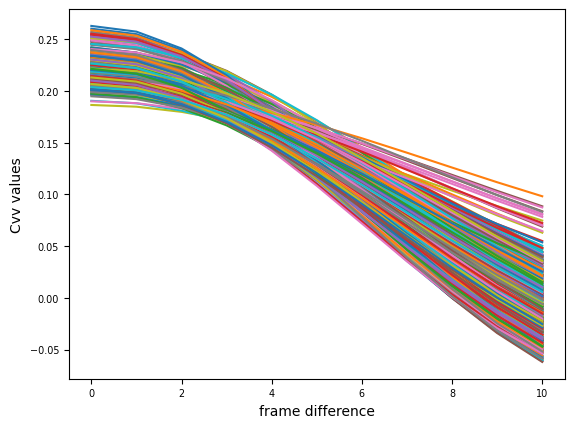

In [50]:
for i in range(681):
    plt.plot(cvv[:, i])
plt.xlabel("frame difference")
plt.ylabel("Cvv values")

In [51]:
# Compute friction and friction_NM: 0th and 5th frame each 681 entries....difference in cvv divide by time -> friction matrix (daig) element wise division
friction = cvv[4, :] - cvv[0, :]
friction = -friction/(5*0.001)
residue_mass = CA.residues.masses/1000
residue_mass = np.repeat(residue_mass, 3)
for i in range(681):
    friction[i] = friction[i]/residue_mass[i]
friction = friction/(8.3144*310*0.001) # ps-1
friction = np.diag(friction)
print(friction)
friction_NM = []
for i in range(20):
    friction_NM.append(Um[i].T @ friction @ Um[i])
print(friction_NM)

[[38.09216   0.        0.       ...  0.        0.        0.      ]
 [ 0.       28.307304  0.       ...  0.        0.        0.      ]
 [ 0.        0.       41.5988   ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ... 42.612473  0.        0.      ]
 [ 0.        0.        0.       ...  0.       34.466457  0.      ]
 [ 0.        0.        0.       ...  0.        0.       40.702126]]
[41.5163389464611, 44.02808478980689, 44.102906186686106, 42.55509668935626, 42.32178272745583, 41.71712292539106, 41.0442214339737, 40.98552815871816, 41.10195752708336, 42.056010758697596, 42.68937284150933, 42.31697568521477, 40.31518427196201, 38.23161377012924, 42.301109843962394, 44.29993739708377, 41.846071008602785, 43.30734227380984, 45.374910774630855, 40.990845670978544]


## 4. Estimating beta_m 

[19.18528118  1.36768897  6.22819656  0.60868555  2.17639933  1.61963378
  2.30881636  0.99732923  2.99925198  2.68753645  3.78002232  1.00029985
  3.77378649  0.47556924  2.22938164  1.17397534  0.21287725  1.11806559
  0.88348227  0.40884542]


Text(0.5, 1.0, 'delT = 75 K')

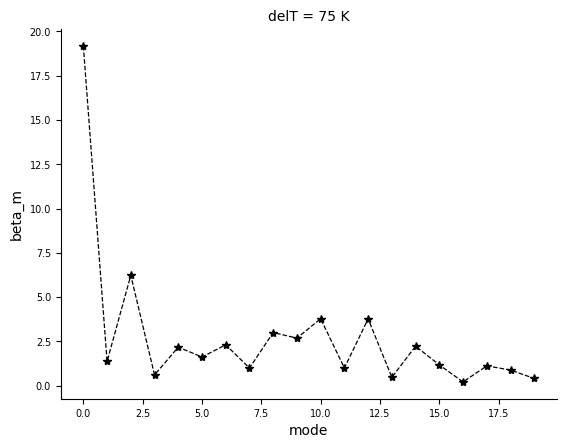

In [52]:
#for delT = 75
a = np.zeros(m)
b = np.zeros(m)
beta_m_75 = np.zeros(m)
for i in range(m):
    a[i] = 0.5 * (-friction_NM[i] + np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    b[i] = 0.5 * (-friction_NM[i] - np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    beta_m_75[i] = alpha_75_20[1][i] * (a[i]-b[i]) / ((np.abs(a[i]/b[i])**(a[i]/(b[i]-a[i])) - np.abs(a[i]/b[i])**(b[i]/(b[i]-a[i]))))
print(beta_m_75)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(beta_m_75, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
ax.set_xlabel('mode', fontsize = 10)
ax.set_ylabel('beta_m', fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 75 K", fontsize = 10)

[7.49472198 5.50387659 7.72000578 2.22508119 1.66875126 1.95758284
 5.27315687 0.75402732 1.99394988 1.6325364  0.33052896 0.55506266
 2.48679096 0.43791583 1.90511295 2.35509384 0.79591752 0.39286312
 2.20931226 0.12795495]


Text(0.5, 1.0, 'delT = 90 K')

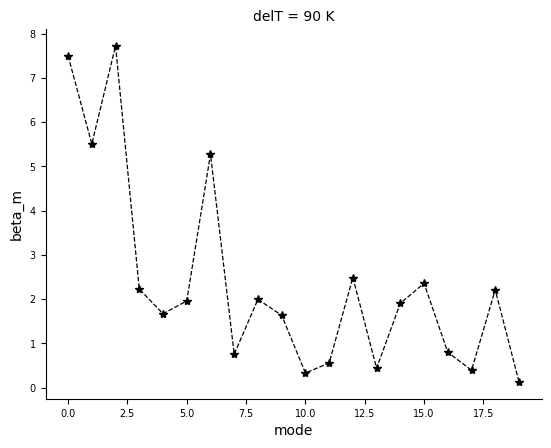

In [53]:
#for delT = 100
a = np.zeros(m)
b = np.zeros(m)
beta_m_90 = np.zeros(m)
for i in range(m):
    a[i] = 0.5 * (-friction_NM[i] + np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    b[i] = 0.5 * (-friction_NM[i] - np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    beta_m_90[i] = alpha_90_20[1][i] * (a[i]-b[i]) / ((np.abs(a[i]/b[i])**(a[i]/(b[i]-a[i])) - np.abs(a[i]/b[i])**(b[i]/(b[i]-a[i]))))
print(beta_m_90)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(beta_m_90, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
ax.set_xlabel('mode', fontsize = 10)
ax.set_ylabel('beta_m', fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 90 K", fontsize = 10)

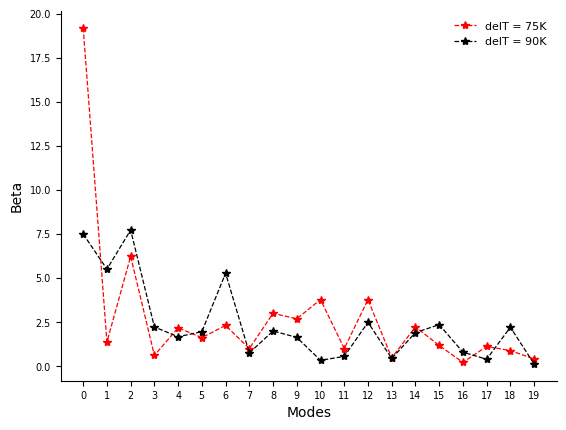

In [54]:
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.plot(mode_lst, beta_m_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
plt.plot(mode_lst, beta_m_90, '*', linestyle='dashed', color = 'black', label = 'delT = 90K', linewidth = 0.9)
plt.xlabel("Modes", fontsize = 10)
plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
plt.ylabel("Beta", fontsize = 10)
#plt.title("Average RMSD for separate modes", fontsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon = False, loc ="upper right", ncol = 1, prop={'size':8})

## 5. Degree of excitation 

In [55]:
# for delT = 75
v_extra = np.zeros(Um[0].shape)
for i in range(m):
    v_extra += beta_m_75[i]*Um[i]
#    v_extra = v_extra/np.linalg.norm(v_extra)
M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

v_excite = np.zeros(antibody.n_atoms*3)
for i in range(antibody.n_residues):
    for j in antibody.residues[i].atoms.indices:
        v_excite[3*j] = v_extra[3*i]
        v_excite[3*j+1] = v_extra[3*i+1]
        v_excite[3*j+2] =  v_extra[3*i+2]
u = mda.Universe(box,box)
alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2) #lambda in nm/ps
#lmda = (alpha* 75)**0.5

Text(0.5, 1.0, 'delT = 75 K')

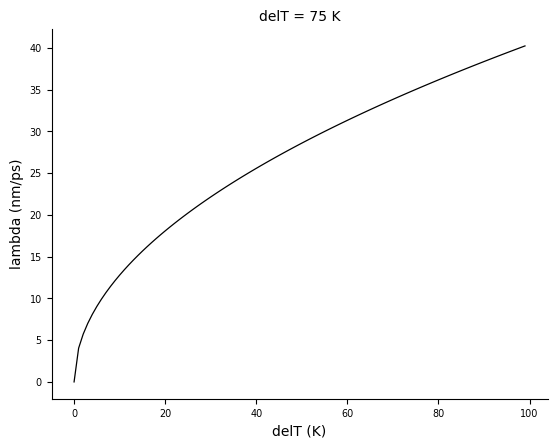

In [56]:
delT = range(0, 100)
lam_75 = []
for k in delT:
    lam_75.append((alpha*k)**0.5)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(delT, lam_75, color = 'black', linewidth = 0.9)
ax.set_xlabel("delT (K)", fontsize = 10)
ax.set_ylabel("lambda (nm/ps)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 75 K", fontsize = 10)

In [57]:
# for delT = 90
v_extra = np.zeros(Um[0].shape)
for i in range(m):
    v_extra += beta_m_90[i]*Um[i]
#    v_extra = v_extra/np.linalg.norm(v_extra)
M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

v_excite = np.zeros(antibody.n_atoms*3)
for i in range(antibody.n_residues):
    for j in antibody.residues[i].atoms.indices:
        v_excite[3*j] = v_extra[3*i]
        v_excite[3*j+1] = v_extra[3*i+1]
        v_excite[3*j+2] =  v_extra[3*i+2]
u = mda.Universe(box,box)
alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2) #lambda in nm/ps
#lmda = (alpha* 75)**0.5

Text(0.5, 1.0, 'delT = 90 K')

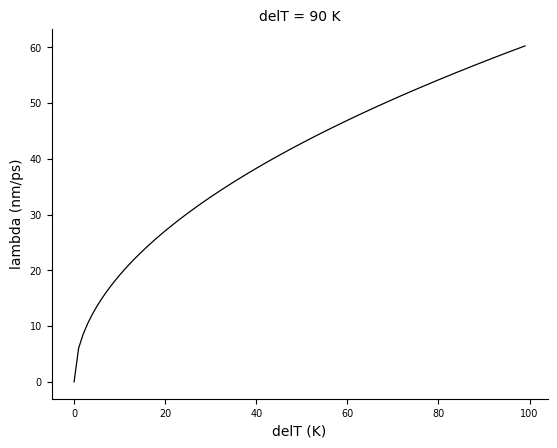

In [58]:
delT = range(0, 100)
lam_90 = []
for k in delT:
    lam_90.append((alpha*k)**0.5)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(delT, lam_90, color = 'black', linewidth = 0.9)
ax.set_xlabel("delT (K)", fontsize = 10)
ax.set_ylabel("lambda (nm/ps)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 90 K", fontsize = 10)

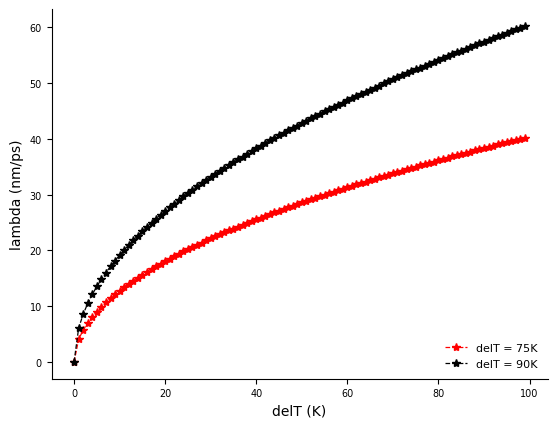

In [59]:
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.plot(delT, lam_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
plt.plot(delT, lam_90, '*', linestyle='dashed', color = 'black', label = 'delT = 90K', linewidth = 0.9)
plt.xlabel("delT (K)", fontsize = 10)
#plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
plt.ylabel("lambda (nm/ps)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon = False, loc ="lower right", ncol = 1, prop={'size':8})

### Excitation along normal modes

In [69]:
box = file_dir+"box.pdb"
pdb = file_dir+"pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')

def excite(Um, box, delT):
    v_extra = np.zeros(Um[0].shape)
    for i in range(m):
        v_extra += beta_m_75[i]*Um[i]
    v_extra = v_extra/ np.linalg.norm(v_extra)
    
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    u = mda.Universe(box,box)
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra.reshape(-1,3)

In [70]:
def save_gro(Um, v_extra, gro_in, delT):
    gro = mda.Universe(gro_in)
    frame = gro.trajectory[-1]
    for i in range(antibody.n_residues):
        for j in gro.residues[i].atoms.indices:
            frame.velocities[j] += v_extra[i]
    filename = file_dir+'withlambda_{}_delT/md.gro'.format(delT)
    print(f"Writing new GRO file to {filename}")
    gro.atoms.write(filename, reindex=False)

In [71]:
gro_in = file_dir+"confout_1.gro"
delT = [10, 20, 30, 40, 50, 60, 70, 75, 80, 85, 90, 95, 100]
for k in delT:
    v_extra = excite(Um, box, k)
    save_gro(Um, v_extra, gro_in, k)

Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_80_delT/withlambda_10_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_80_delT/withlambda_20_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_80_delT/withlambda_30_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_80_delT/withlambda_40_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_80_delT/withlambda_50_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_80_delT/withlambda_60_delT

## New structures (excitation alogn direction of min energy)

In [72]:
box = file_dir+"box.pdb"
pdb = file_dir+"pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')

def excite(Um, box, delT):
    v_extra = np.zeros(Um[0].shape)
    for i in range(m):
        v_extra += beta_m_75[i]*Um[i]
    v_extra = v_extra/ np.linalg.norm(v_extra)
    
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    u = mda.Universe(box,box)
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra

def residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, selection, Um, delT):
    u = mda.Universe(pdb_mdenm, xtc_mdenm)
    v = mda.Universe(pdb_ref, pdb_ref)
    v_lrt = excite(Um, box, delT)
    v_lrt = v_lrt/np.linalg.norm(v_lrt) 
    u_fvca = u.select_atoms(selection)
    v_fvca = v.select_atoms(selection)
    dp = []
    for _ in u.trajectory:
        _ = align.alignto(u_fvca, v_fvca)
        deformation = (u_fvca.positions - v_fvca.positions).flatten()
        dp.append((np.dot(deformation, v_lrt)**2/u_fvca.n_residues)**0.5)
    return np.array(dp)

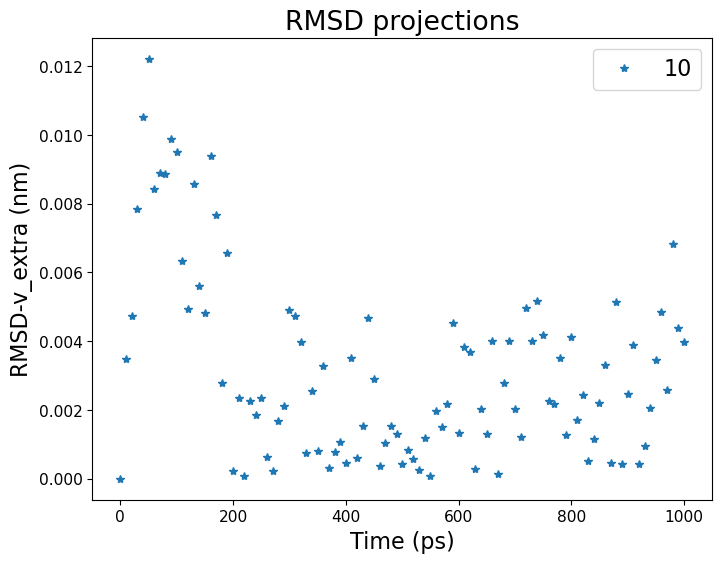

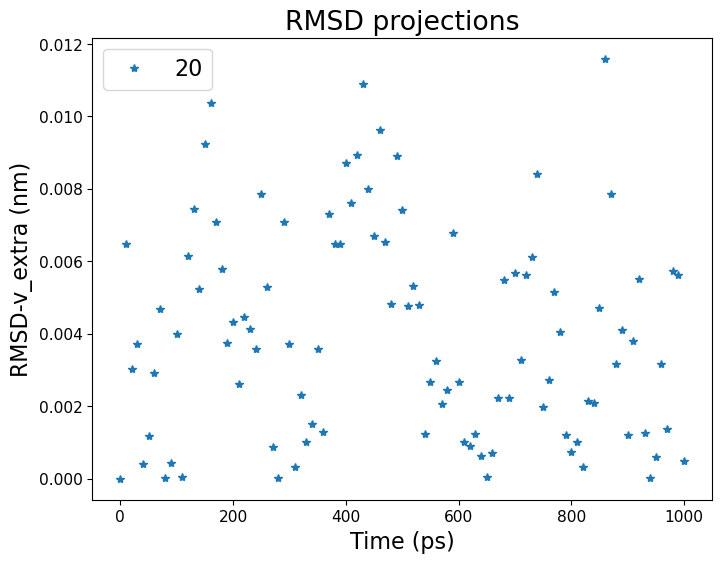

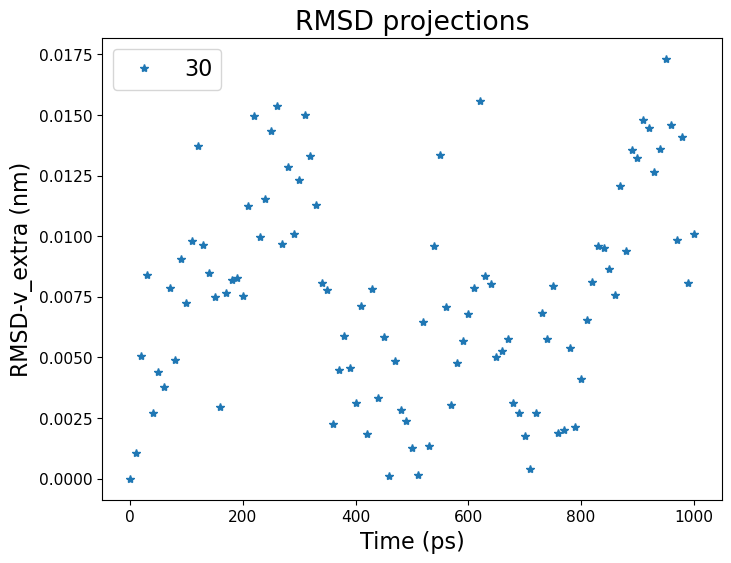

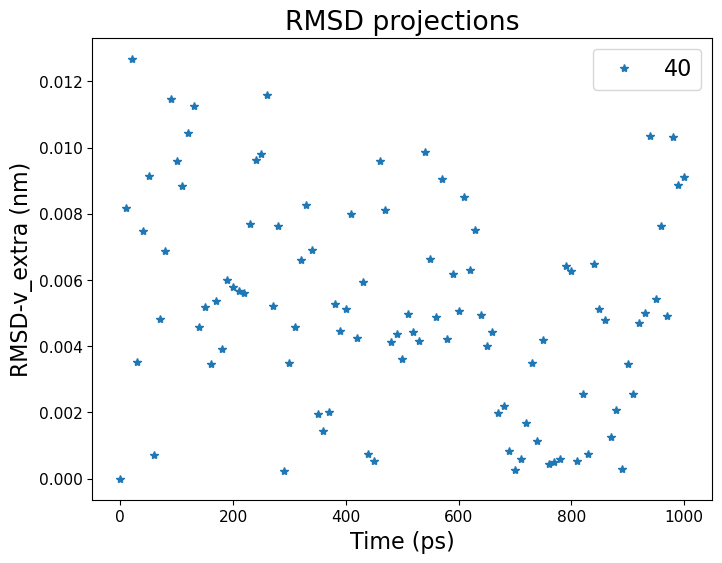

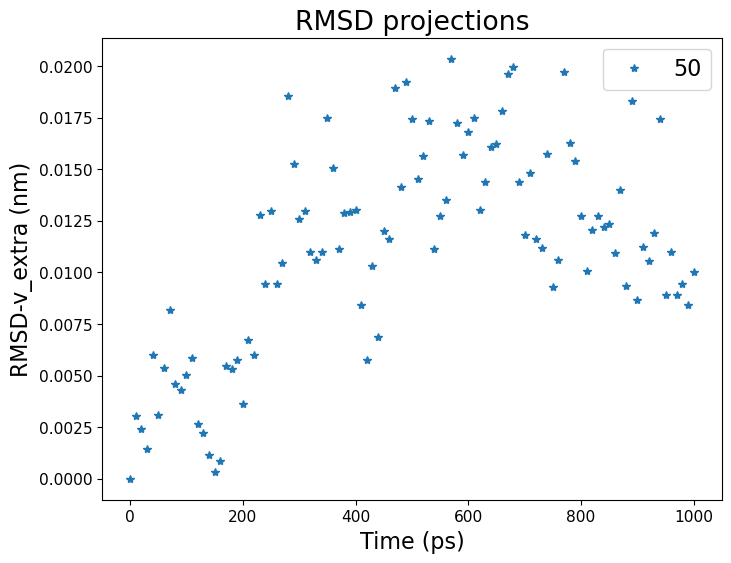

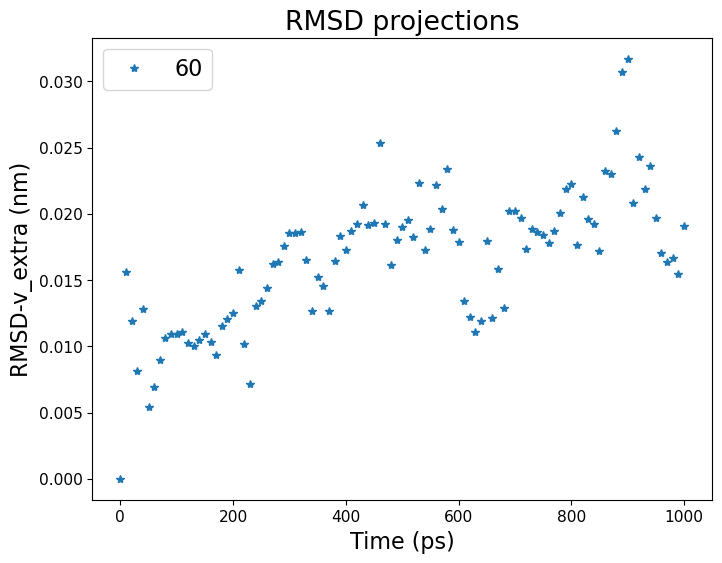

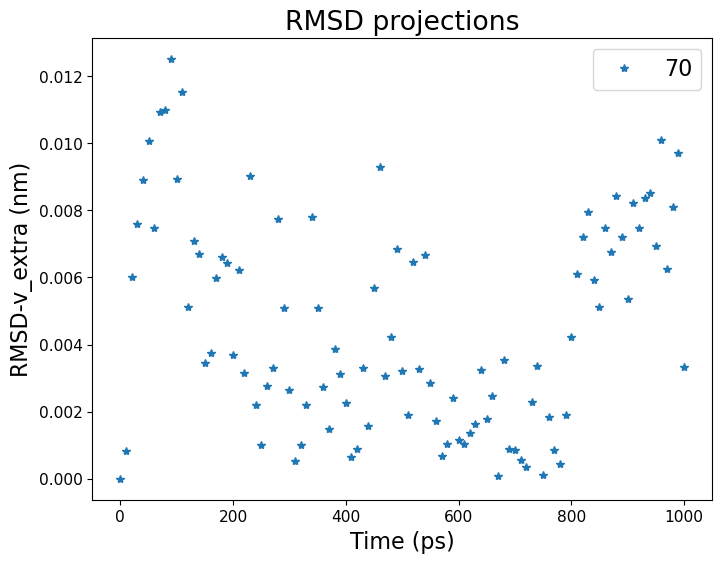

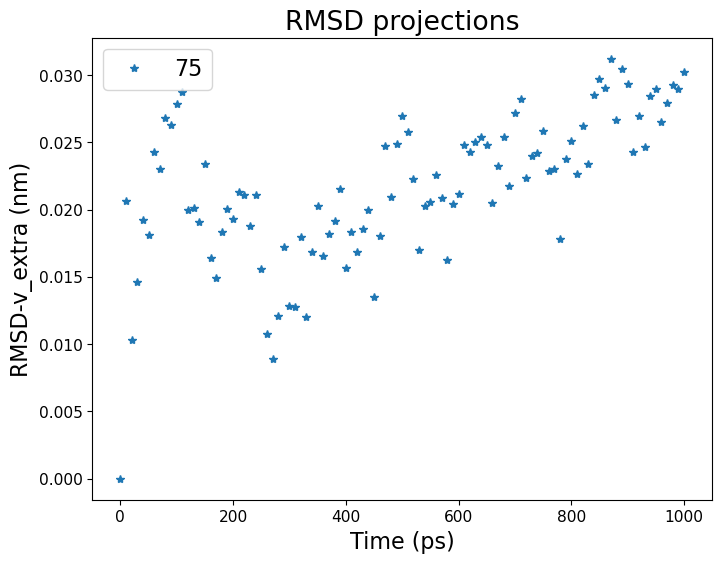

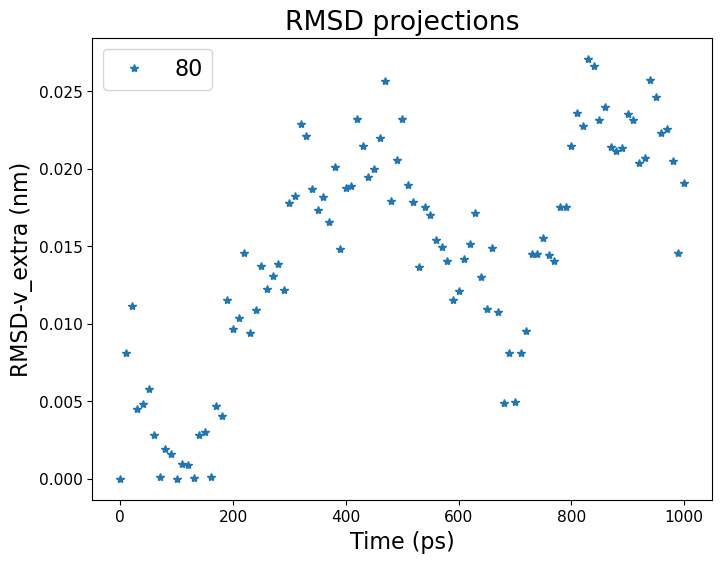

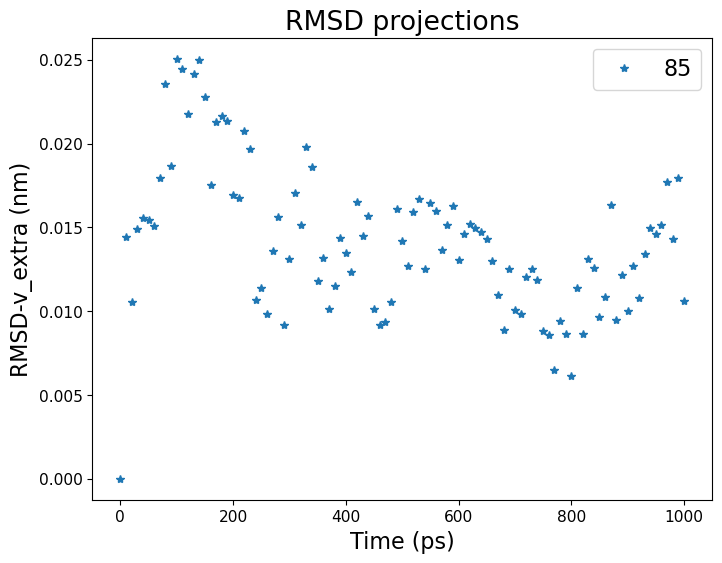

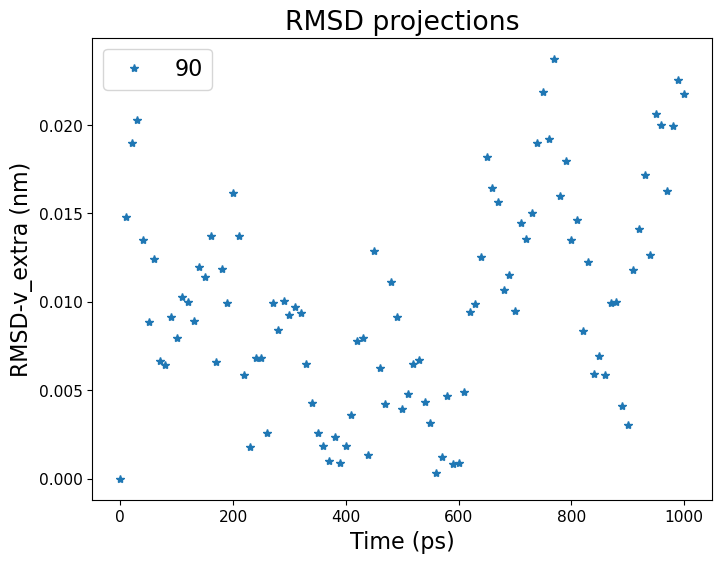

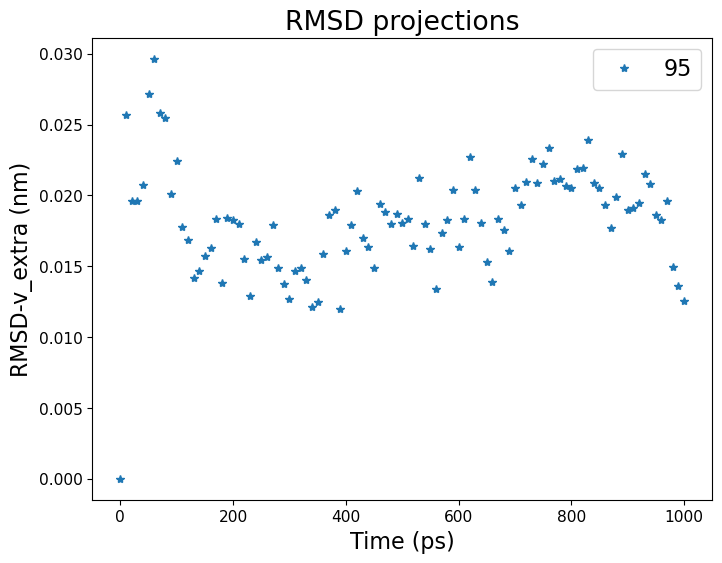

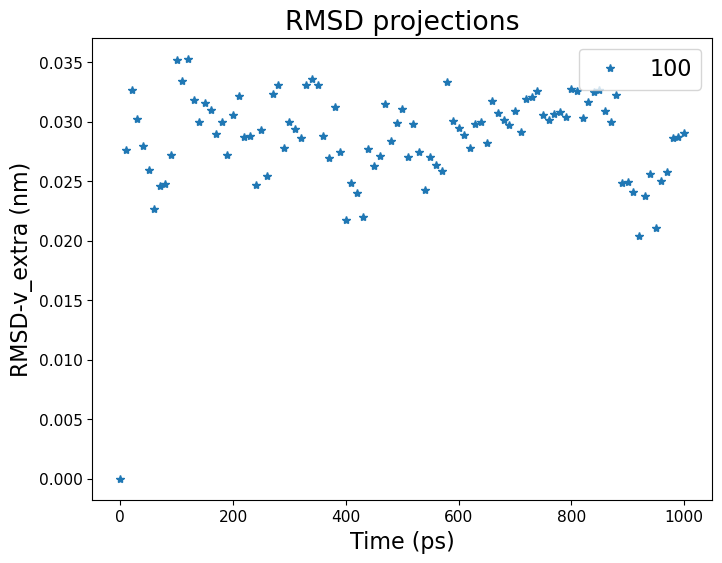

In [73]:
delT = [10, 20, 30, 40, 50, 60, 70, 75, 80, 85, 90, 95, 100]
prmsd = []
time = [i*10 for i in range(101)]
for k in range(len(delT)):
    pdb_mdenm = file_dir+"withlambda_{}_delT/pdb_mdenm.pdb".format(delT[k])
    xtc_mdenm = file_dir+"withlambda_{}_delT/xtc_mdenm.xtc".format(delT[k])
    pdb_ref = file_dir+"pdb_ref.pdb"
    z_v = [residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, '(chainID A or chainID B) and name CA', Um, delT[k])]
    z_v = z_v[0]
    z_v = [i*0.1 for i in (z_v)]
    prmsd.append(z_v)
    plt.figure(figsize=(8,6))
    plt.rcParams['font.size'] = '16'
    plt.plot(time, z_v, '*')
    plt.title('RMSD projections')
    plt.xlabel('Time (ps)')
    plt.ylabel('RMSD-v_extra (nm)')
    plt.legend([str(delT[k])])

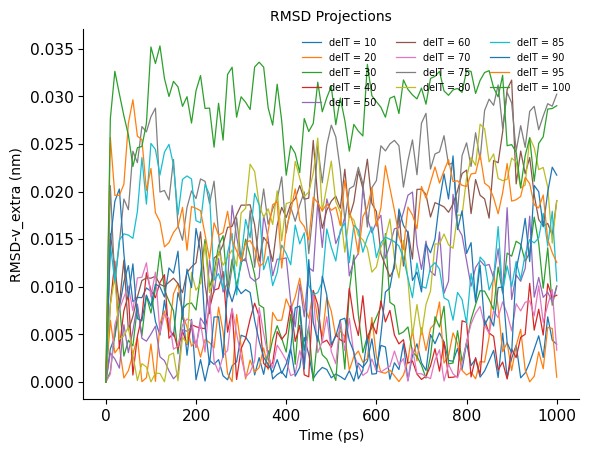

In [74]:
time = [i*10 for i in range(101)]
fig, ax = plt.subplots()
for k in range(len(delT)): 
    ax.plot(time, prmsd[k], label = 'delT = {}'.format(str(delT[k])), linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 3, prop={'size':7})
    ax.set_xlabel('Time (ps)', fontsize = 10)
    ax.set_ylabel('RMSD-v_extra (nm)', fontsize = 10)
#    ax.set_ylim(0, 0.09)
    ax.set_title('RMSD Projections', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
plt.show()

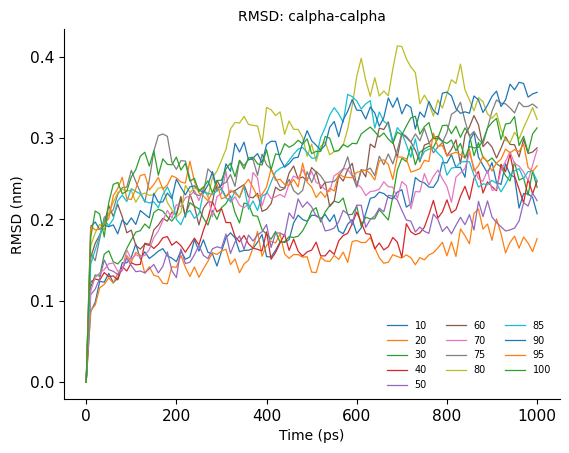

In [75]:
rmsd = []
fig, ax = plt.subplots()
for k in range(len(delT)):
    filename = file_dir+"withlambda_{}_delT/rmsd_calpha_calpha.xvg".format(delT[k])
    rmsd_value = np.genfromtxt(filename, skip_header = 18)
    rmsd.append(rmsd_value[:, 1])
    ax.plot(rmsd_value[:, 0], rmsd_value[:, 1], label = str(delT[k]), linewidth = 0.9)
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.set_xlabel("Time (ps)", fontsize = 10)
ax.set_ylabel("RMSD (nm)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("RMSD: calpha-calpha", fontsize = 10)
plt.legend(frameon = False, loc='lower right', ncol = 3, prop={'size':7})

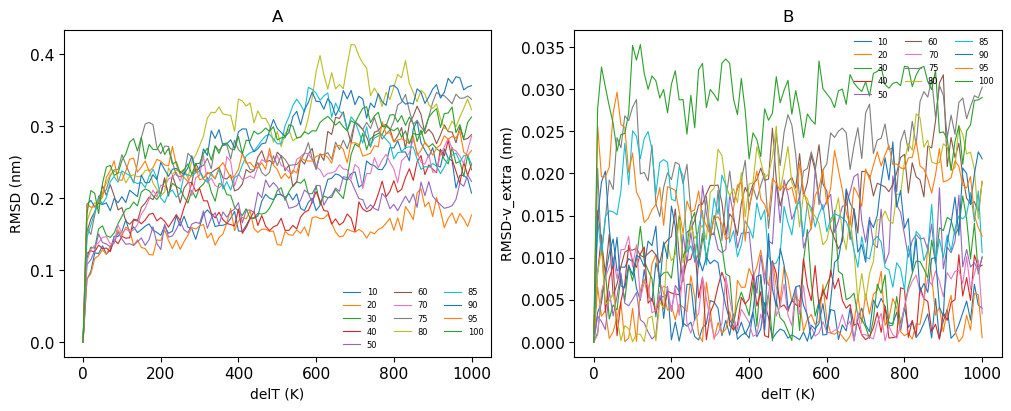

In [76]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for k in range(len(delT)):
    axes[0].plot(time, rmsd[k], label = str(delT[k]), linewidth = 0.8)
    axes[0].set_xlabel("delT (K)", fontsize = 10)
    axes[0].set_ylabel("RMSD (nm)", fontsize = 10)
    axes[0].set_title("A", fontsize = 12)
    axes[0].legend(frameon = False, loc ="lower right", ncol = 3, prop={'size':6})
    axes[1].plot(time, prmsd[k], label = str(delT[k]), linewidth = 0.8)
    axes[1].set_xlabel("delT (K)", fontsize = 10)
    axes[1].set_ylabel("RMSD-v_extra (nm)", fontsize = 10)
    axes[1].set_title("B", fontsize = 12)
#    axes[1].set_ylim(0, 0.09)
    axes[1].legend(frameon = False, loc ="upper right", ncol = 3, prop={'size':6})

Text(0.5, 1.0, 'B')

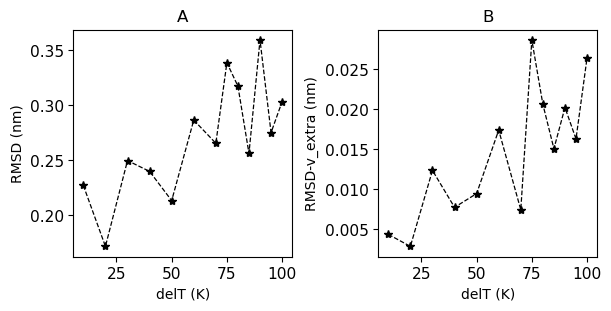

In [77]:
avg_rmsd = []
avg_prmsd = []
for k in range(len(delT)):
    avg_rmsd.append(np.average(rmsd[k][95:]))
    avg_prmsd.append(np.average(prmsd[k][95:]))

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

axes[0].plot(delT, avg_rmsd, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
axes[0].set_xlabel("delT (K)", fontsize = 10)
axes[0].set_ylabel("RMSD (nm)", fontsize = 10)
axes[0].set_title("A", fontsize = 12)
axes[1].plot(delT, avg_prmsd, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
axes[1].set_xlabel("delT (K)", fontsize = 10)
axes[1].set_ylabel("RMSD-v_extra (nm)", fontsize = 10)
axes[1].set_title("B", fontsize = 12)
    
# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(delT, avg_rmsd, '*', linestyle='dashed', color = 'grey')
# plt.xlabel("delT (K)", fontsize = 14)
# plt.ylabel("RMSD (nm)", fontsize = 14)
# plt.title("Average RMSD wrt delT", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(delT, avg_prmsd, '*', linestyle='dashed', color = 'grey')
# plt.xlabel("delT (K)", fontsize = 14)
# plt.ylabel("RMSD-v_extra (nm)", fontsize = 14)
# plt.title("Average RMSD projections wrt delT", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)